In [30]:
import numpy as np
import logging
from tqdm import tqdm
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
import pandas as pd
import os

# Configure logging
# logging.basicConfig(level=logging.DEBUG, format='%(levelname)s:%(message)s')
logger = logging.getLogger()


font = {'family': 'Arial',
        'weight': 'normal',
        'size': 14}
plt.rc('font', **font)

# ================== Utility Functions ==================
def softmax(x):
    """Compute softmax values for each set of scores in x."""
    e_x = np.exp(x - np.max(x))  # Stability improvement
    return e_x / e_x.sum()

def gini(x):
    """Robust Gini Coefficient Calculation"""
    x = np.sort(x)
    n = len(x)
    if n == 0 or np.sum(x) == 0:
        return 0.0
    cumx = np.cumsum(x, dtype=float)
    return (n + 1 - 2 * np.sum(cumx)/cumx[-1])/n

def sigmoid(x):
    """Sigmoid activation function."""
    return 1 / (1 + np.exp(-x))

def jain_fairness(x):
    """Improved Jain Index Calculation"""
    x = np.array(x)
    if np.sum(x) == 0:
        return 0.0
    return (np.sum(x)**2) / (len(x)*np.sum(x**2) + 1e-8) * sigmoid(np.mean(x)/10)

# ================== Node Class ==================
class Node:
    """Enhanced Federated Learning Node"""
    def __init__(self, node_id, init_stake=100, init_rep=100):
        self.id = node_id
        self.stake = init_stake
        self.reputation = init_rep
        self.total_reward = 0
        self.violations = 0
        self.participation = 0
        self.contrib_history = []
        self.cooldown = 0
        self.last_violation_round = -np.inf
        self.consecutive_committee = 0
        self.total_committee = 0
        self.identity_verified = True  # All nodes are verified

    def update_committee_status(self, is_in_committee):
        """Update committee status (including cooldown mechanism)"""
        if is_in_committee and self.cooldown <= 0:
            self.consecutive_committee += 1
            self.total_committee += 1
            self.cooldown = 3  # Example cooldown period
            logger.debug(f"Node {self.id} selected for committee. Cooldown set to {self.cooldown}.")
        else:
            if is_in_committee and self.cooldown > 0:
                logger.debug(f"Node {self.id} attempted to join committee but is in cooldown.")
            self.consecutive_committee = 0
        # Decrement cooldown if greater than 0
        if self.cooldown > 0:
            self.cooldown = max(0, self.cooldown - 1)
            logger.debug(f"Node {self.id} cooldown decremented to {self.cooldown}.")

    def act_normal(self):
        """Normal behavior pattern (with random fluctuation)"""
        base = np.random.normal(7, 1)
        fluctuation = np.random.choice([0.8, 1.0, 1.2], p=[0.2, 0.6, 0.2])
        contrib = max(0, base * fluctuation)
        self.contrib_history.append(contrib)
        logger.debug(f"Node {self.id} acted normally with contribution {contrib:.2f}.")
        return contrib

    def act_malicious(self, phase):
        """Enhanced robust malicious behavior method"""
        try:
            phase = int(phase)
            if phase == 1:  # High contribution attack
                contrib = max(9.5, np.random.normal(9.8, 0.3))
            elif phase == 2:    # Zero contribution attack
                contrib = 0
            elif phase == 3:    # Random attack (60% high contrib, 40% zero)
                contrib = np.random.choice([10, 0], p=[0.6, 0.4])
            else:
                raise ValueError(f"Invalid attack phase: {phase}")
        except Exception as e:
            logger.error(f"Node {self.id} attack phase error: {str(e)}")
            contrib = 0  # Safe default value

        self.contrib_history.append(contrib)
        logger.debug(f"Node {self.id} acted maliciously with contribution {contrib}.")
        return contrib

# ================== FLSystem Class ==================
class FLSystem:
    """Federated Learning System Simulator (Optimized for Stratified Sampling)"""
    def __init__(self, 
                 num_nodes=100,
                 base_reward=1000,
                 committee_size=10,
                 stake_weight=0.4,
                 rep_exponent=0.5,
                 init_stake=100,
                 init_rep=100,
                 malicious_ratio=0.1,
                 phase_switch_round=25,
                 sybil_resistance=False):  # Sybil resistance not needed
        # Save parameters as instance attributes
        self.sybil_resistance = sybil_resistance  # Not used in selection
        
        # Initialize nodes
        self.nodes = [Node(i+1, init_stake, init_rep) for i in range(num_nodes)]
        
        # Initialize malicious nodes
        self.malicious_nodes = self._init_malicious_nodes(malicious_ratio)
        
        # System parameters
        self.base_reward = base_reward
        self.malicious_ratio = malicious_ratio
        self.committee_size = committee_size
        self.stake_weight = stake_weight
        self.rep_exponent = rep_exponent
        self.phase_switch_round = phase_switch_round
        
        # Tracking state
        self.current_round = 0
        self.reputation_history = []
        self.reward_history = []
        self.gini_history = []
        self.fairness_history = []
        self.detection_history = []
        self.committee_history = []  # Committee history
        self.penalty_history = []  # Penalty history

    def _init_malicious_nodes(self, ratio):
        """Initialize malicious nodes (all nodes are verified)"""
        num_malicious = int(len(self.nodes) * ratio)
        malicious = self.nodes[:num_malicious]
        logger.info(f"Initialized {num_malicious} malicious nodes.")
        return malicious  # All malicious nodes are verified

    def _dynamic_malicious_threshold(self):
        """Dynamically calculate the threshold for malicious node detection"""
        # Get the latest contribution values of all nodes
        contribs = []
        for n in self.nodes:
            if n.contrib_history:
                contribs.append(n.contrib_history[-1])
            else:
                contribs.append(0)
        
        # Calculate the 30th percentile and adjust
        percentile_30 = np.percentile(contribs, 30)
        threshold = percentile_30 * 0.7 + 1e-8  # Add a tiny value to prevent division by zero
        logger.debug(f"Dynamic malicious threshold calculated: {threshold:.4f}")
        return threshold

    def select_committee(self, num_strata=3):
        """
        Select committee members using stratified sampling based on reputation and cooldown.

        Parameters:
            num_strata (int): Number of strata to divide the nodes into.

        Returns:
            selected (list): List of selected committee nodes.
        """
        # Sort nodes by reputation descending
        sorted_nodes = sorted(self.nodes, key=lambda x: x.reputation, reverse=True)
        strata_size = len(sorted_nodes) // num_strata
        strata = [sorted_nodes[i*strata_size : (i+1)*strata_size] for i in range(num_strata)]
        
        # Handle any remaining nodes by adding to the last stratum
        if len(sorted_nodes) % num_strata != 0:
            strata[-1].extend(sorted_nodes[num_strata*strata_size:])
            logger.debug(f"Added {len(sorted_nodes) % num_strata} nodes to the last stratum.")

        selected = []
        quotas = [self.committee_size // num_strata] * num_strata  # Initial quota per stratum
        remaining_quota = self.committee_size - sum(quotas)

        # Distribute remaining_quota among the first few strata
        for i in range(remaining_quota):
            quotas[i % num_strata] += 1
        logger.debug(f"Final Quotas per Stratum: {quotas}")

        # First Pass: Select based on strata quotas
        for idx, (stratum, quota) in enumerate(zip(strata, quotas)):
            # Filter eligible candidates (not in cooldown)
            candidates = [node for node in stratum if node.cooldown <= 0]
            eligible_count = len(candidates)
            logger.debug(f"Stratum {idx+1}: {eligible_count} eligible candidates.")

            if eligible_count == 0:
                logger.debug(f"Stratum {idx+1} has no eligible candidates. Quota remains unfilled.")
                continue  # Quota will be redistributed later

            # Determine how many to select from this stratum
            select_count = min(quota, eligible_count)
            select_count = max(1, select_count)  # Ensure at least one selection if possible

            # Calculate selection probabilities based on reputation
            if eligible_count == 1:
                probabilities = [1.0]
            else:
                reputation_scores = np.array([node.reputation for node in candidates], dtype=float)
                probabilities = softmax(reputation_scores ** self.rep_exponent)
            
            # Select nodes
            selected_nodes = np.random.choice(candidates, size=select_count, p=probabilities, replace=False)
            selected.extend(selected_nodes)
            logger.debug(f"Stratum {idx+1}: Selected {select_count} nodes.")

        # Check if committee size is met
        if len(selected) < self.committee_size:
            logger.debug(f"Committee size after first pass: {len(selected)}. Redistributing remaining quota.")
            remaining_quota = self.committee_size - len(selected)
            
            # Gather all eligible nodes not yet selected
            eligible_nodes = [node for node in self.nodes if node.cooldown <= 0 and node not in selected]
            eligible_count = len(eligible_nodes)
            logger.debug(f"Total eligible nodes for redistribution: {eligible_count}.")

            if eligible_count >= remaining_quota:
                if eligible_count == 1:
                    probabilities = [1.0]
                else:
                    reputation_scores = np.array([node.reputation for node in eligible_nodes], dtype=float)
                    probabilities = softmax(reputation_scores ** self.rep_exponent)
                
                # Select remaining_quota nodes
                selected_nodes = np.random.choice(eligible_nodes, size=remaining_quota, p=probabilities, replace=False)
                selected.extend(selected_nodes)
                logger.debug(f"Redistributed and selected {remaining_quota} additional nodes.")
            elif eligible_count > 0:
                # Select all remaining eligible nodes
                selected.extend(eligible_nodes)
                logger.warning(f"Only {eligible_count} eligible nodes available for redistribution. Committee size reduced.")
        
        # Final Check
        if len(selected) < self.committee_size:
            logger.warning(f"Unable to fill the committee to the desired size of {self.committee_size}. "
                           f"Only {len(selected)} members selected.")
        else:
            logger.debug(f"Successfully selected {len(selected)} committee members.")
        
        # Update node statuses
        for node in self.nodes:
            node.update_committee_status(node in selected)
        
        self.committee_history.append([node.id for node in selected])
        logger.info(f"Round {self.current_round + 1}: Committee selected with {len(selected)} members.")
        
        return selected

    def calculate_reward(self, node, avg_rep):
        """Dynamic hybrid reward calculation"""
        # Effective stake (anti-monopoly)
        avg_stake = np.mean([n.stake for n in self.nodes])
        effective_stake = min(node.stake, avg_stake * 3)
        
        # Time-decayed contribution
        hist_contrib = sum(c * (0.9**t) for t, c in enumerate(reversed(node.contrib_history[-5:])))
        
        # Dynamic weights using sigmoid function
        alpha = sigmoid((avg_rep - 100)/50) * self.stake_weight
        beta = 1 - alpha
        
        # Diversity bonus
        # diversity_bonus = 1 - gini([n.reputation for n in self.nodes])
        diversity_bonus = jain_fairness([n.reputation for n in self.nodes])

        # Committee reward
        committee_reward = 40 * diversity_bonus if node in self.committee_history[-1] else 0
        
        # Total reward calculation
        total = (alpha * self.base_reward * (effective_stake / (sum(n.stake for n in self.nodes) + 1e-8)) +
                beta * self.base_reward * (hist_contrib / (sum(n.contrib_history[-1] for n in self.nodes) + 1e-8)) +
                committee_reward) * diversity_bonus
        
        return max(total, 0)

    def update_reputation(self, node, contribution):
        """Robust reputation update system"""
        # Dynamic decay
        age_factor = 1 - 1/(1 + node.participation/100)
        delta = 0.88 + 0.07 * age_factor
        
        # Contribution quality
        contrib_base = 0
        contrib_thre = 10
        contrib_quality = sigmoid((contribution-contrib_base)/(contrib_thre - contrib_base))
        
        # Stability evaluation
        if len(node.contrib_history) >= 5:
            stability = 1 - np.std(node.contrib_history[-5:])/5
        else:
            stability = 0.8
            
        new_rep = (node.reputation * delta +
                  contrib_quality * 50 +
                  stability * 30)
        
        # Dynamic cap
        rep_cap = 500 if self.current_round > 50 else 300
        return np.clip(new_rep, 0, rep_cap)

    def detect_malicious(self, node):
        """Hybrid detection strategy"""
        # Basic detection
        if len(node.contrib_history) < 5:
            return False
        
        window = node.contrib_history[-5:]
        avg = np.mean(window)
        std = np.std(window)
        threshold = self._dynamic_malicious_threshold()
        
        # Rule 1: Persistent low contributions
        condition1 = avg < threshold * 0.7
        
        # Rule 2: Abnormal fluctuation
        condition2 = std < threshold * 0.4
        
        # Rule 3: Sudden behavior change
        prev_avg = np.mean(node.contrib_history[-10:-5]) if len(node.contrib_history) >= 10 else 7
        condition3 = abs(avg - prev_avg) > 5
        
        is_malicious = (condition1 and condition2) or condition3
        logger.debug(f"Node {node.id} detection: Condition1={condition1}, Condition2={condition2}, Condition3={condition3} -> {is_malicious}")
        return is_malicious

    def run_round(self):
        """Execute simulation round"""        
        # Improved phase calculation logic
        base_phase = 1 if self.current_round < self.phase_switch_round else 2
        phase_variation = int(self.current_round/30) % 2
        attack_phase = min(base_phase + phase_variation, 3)
        logger.info(f"Round {self.current_round + 1}: Phase {attack_phase}")
        
        contributions = []  # Initialize contributions list
        
        # Collect all nodes' contributions
        for node in self.nodes:
            if node in self.malicious_nodes:
                contrib = node.act_malicious(attack_phase)
            else:
                contrib = node.act_normal()
            contributions.append(contrib)  # Add this line

        # Committee selection
        self.committee = self.select_committee()
        
        # System updates
        avg_rep = np.mean([n.reputation for n in self.nodes])
        rewards = []
        detected = 0
        penalties = []
        
        for node, contrib in zip(self.nodes, contributions):
            # Detection and penalty
            if self.detect_malicious(node):
                penalty = min(0.3 * node.reputation + 0.1 * node.stake, node.reputation*0.5)
                penalties.append(penalty)
                node.reputation -= penalty
                node.violations += 1
                detected += 1
                logger.debug(f"Node {node.id} detected as malicious. Penalty applied: {penalty:.2f}")
            else:
                node.reputation = self.update_reputation(node, contrib)
                logger.debug(f"Node {node.id} reputation updated to {node.reputation:.2f}")
            
            # Reward calculation
            reward = self.calculate_reward(node, avg_rep)
            node.total_reward += reward
            rewards.append(reward)
            logger.debug(f"Node {node.id} received reward: {reward:.2f}")
            
            node.participation += 1

        # Record metrics
        self.penalty_history.append(penalties)
        self.reputation_history.append([n.reputation for n in self.nodes])
        self.reward_history.append(rewards)
        self.gini_history.append(gini(rewards))
        self.fairness_history.append(jain_fairness(rewards))
        self.detection_history.append(detected)
        self.current_round += 1
        logger.info(f"Round {self.current_round}: Detected {detected} malicious nodes.")

# ================== Visualization Module ==================
def plot_metrics(system, label="System"):
    """System-Wide Metrics Visualization"""
    
    plt.figure(figsize=(8, 6))

    # ---------- Fairness metrics -------------
    # plt.subplot(2, 2, 1)
    # rewards = np.array(system.reward_history)
    # rounds = np.arange(rewards.shape[0])
    # num_nodes = rewards.shape[1]

    # plt.plot(system.gini_history, linewidth=3, label='Gini Coefficient')
    # plt.plot(system.fairness_history, linewidth=3, label="Jain's Fairness Index")
    # plt.axhline(0.3, color='green', linestyle='--', label='Healthy Gini Threshold')
    # plt.axhline(1, color='red', linestyle='--', label='Ideal Fairness Threshold')
    # plt.title(f'Fairness Metric Dynamics\nTotal Nodes: {num_nodes} | Rounds: {len(rounds)}',
    #         #    | Lable: {label}', 
    #          fontsize=14, pad=20)
    # plt.xlabel('Round', fontsize=14)
    # plt.ylabel('Ratio', fontsize=14)
    # plt.grid(True, linestyle='--', alpha=0.6)

    # plt.legend()
    # plt.tight_layout()
    
    # # --------- Reputation Distribution -----------
    # plt.subplot(2, 2, 2)
    # if not system.reputation_history:
    #     print("警告：无声誉数据可供可视化")
    #     plt.title('声誉数据未找到')
    #     return
    
    # reps = np.array(system.reputation_history)
    # rounds = np.arange(reps.shape[0])
    # num_nodes = reps.shape[1]
    
    # # Identify malicious nodes
    # malicious_ids = [n.id-1 for n in system.malicious_nodes] if system.malicious_nodes else []
    # honest_ids = [i for i in range(num_nodes) if i not in malicious_ids]
    
    # # Plot individual traces with group coloring
    # for node_id in range(num_nodes):
    #     color = 'tomato' if node_id in malicious_ids else 'skyblue'
    #     alpha = 0.2 if node_id in malicious_ids else 0.1
    #     plt.plot(rounds, reps[:, node_id], 
    #             color=color, 
    #             alpha=alpha, 
    #             linewidth=0.8,
    #             zorder=1)
    
    # # Calculate group averages
    # if malicious_ids:
    #     malicious_avg = np.mean(reps[:, malicious_ids], axis=1)
    #     malicious_q1 = np.percentile(reps[:, malicious_ids], 25, axis=1)
    #     malicious_q3 = np.percentile(reps[:, malicious_ids], 95, axis=1)
    # else:
    #     malicious_avg = np.array([])
    #     malicious_q1 = np.array([])
    #     malicious_q3 = np.array([])
    
    # honest_avg = np.mean(reps[:, honest_ids], axis=1)
    # honest_q1 = np.percentile(reps[:, honest_ids], 25, axis=1)
    # honest_q3 = np.percentile(reps[:, honest_ids], 95, axis=1)
    
    # # Plot group averages
    # plt.plot(rounds, honest_avg, 
    #         color='dodgerblue', 
    #         linewidth=3, 
    #         linestyle='-',
    #         label=f'Honest Nodes Avg (μ={honest_avg[-1]:.1f})',
    #         zorder=4)
    
    # if len(malicious_avg) > 0:
    #     plt.plot(rounds, malicious_avg, 
    #             color='crimson', 
    #             linewidth=3, 
    #             linestyle='--',
    #             label=f'Malicious Nodes Avg (μ={malicious_avg[-1]:.1f})',
    #             zorder=5)

    # # Plot overall mean comparison
    # total_avg = np.mean(reps, axis=1)
    # plt.plot(rounds, np.mean(reps, axis=1),
    #         color='gold', 
    #         linewidth=3,
    #         linestyle=':',
    #         label='Overall Mean',
    #         zorder=3)
    
    # # Plot honest nodes statistics
    # plt.fill_between(rounds, honest_q1, honest_q3,
    #                 color='skyblue', alpha=0.3,
    #                 label='Honest IQR', zorder=2)
    # plt.plot(rounds, honest_avg,
    #         color='dodgerblue', lw=3,
    #         label=f'[{len(honest_ids)}] Honest Avg (Final: {honest_avg[-1]:.1f})')
    
    # # Plot malicious nodes statistics (if any)
    # if len(malicious_avg) > 0:
    #     plt.fill_between(rounds, malicious_q1, malicious_q3,
    #                     color='lightcoral', alpha=0.3,
    #                     label='Malicious IQR', zorder=2)
    #     plt.plot(rounds, malicious_avg,
    #             color='crimson', lw=3, linestyle='--',
    #             label=f'[{len(malicious_ids)}] Malicious Avg (Final: {malicious_avg[-1]:.1f})')
    
    # # Formatting
    # plt.title(f'Reputation Distribution Dynamics\n'
    #          f'Total Nodes: {num_nodes} (Malicious: {len(malicious_ids)}) | Rounds: {len(rounds)}',
    #         #    | Label: {label}', 
    #          fontsize=14, pad=20)
    # plt.xlabel('Round', fontsize=14)
    # plt.ylabel('Reputation Value', fontsize=14)
    # plt.grid(True, linestyle='--', alpha=0.6)
    
    # # Create layered legend
    # legend_elements = [
    #     Patch(facecolor='skyblue', alpha=0.3, label='Honest IQR'),
    #     Line2D([0], [0], color='dodgerblue', lw=2, label=f'Honest Average'),
    # ]
    
    # if len(malicious_avg) > 0:
    #     legend_elements.extend([
    #         Patch(facecolor='lightcoral', alpha=0.3, label='Malicious IQR'),
    #         Line2D([0], [0], color='crimson', lw=2, ls='--', label=f'Malicious Average'),
    #     ])
    
    # legend_elements.extend([
    #     Line2D([0], [0], color='gold', lw=2, ls=':', label='Overall Mean'),
    #     Line2D([0], [0], color='skyblue', alpha=0.3, lw=1, label='Honest Traces'),
    # ])
    
    # if len(malicious_avg) > 0:
    #     legend_elements.append(Line2D([0], [0], color='tomato', alpha=0.3, lw=1, label='Malicious Traces'))
    
    # plt.legend(handles=legend_elements, 
    #           loc='upper center',
    #           bbox_to_anchor=(0.25, 0.4),  
    #           ncol=1,
    #           frameon=False,
    #           fontsize=12)
    
    # # Add dynamic statistical annotations
    # stats_text = []
    # if len(malicious_avg) > 0:
    #     stats_text.append(f"Malicious Reputation Δ: {malicious_avg[-1]-malicious_avg[0]:.1f}")
    # stats_text.extend([
    #     f"Honest Reputation Δ: {honest_avg[-1]-honest_avg[0]:.1f}",
    #     f"Final Reputation Range: {np.min(reps[-1]):.1f}-{np.max(reps[-1]):.1f}",
    #     # f"Honest/Honest Ratio: {honest_avg[-1]/(total_avg[-1]+1e-8):.2f}x"
    # ])
    
    # plt.annotate('\n'.join(stats_text), 
    #             xy=(0.96, 0.7),
    #             xycoords='axes fraction',
    #             ha='right',
    #             va='bottom',
    #             fontsize=12,
    #             bbox=dict(boxstyle='round', alpha=0.2, facecolor='white'))

    
    # # -------- Security Detection ------------
    # plt.subplot(2, 2, 3)
    # if malicious_ids:
    #     plt.bar(range(len(system.detection_history)), system.detection_history, alpha=0.6)
    #     plt.title(f'Malicious Node Detection\n'
    #               f'Nodes: {num_nodes} (Malicious: {len(malicious_ids)}) | Rounds: {len(rounds)}',
    #               fontsize=14, pad=20)
    #     plt.xlabel('Round', fontsize=14)
    #     plt.ylabel('Total Detected', fontsize=14)
    #     plt.grid(True, linestyle='--', alpha=0.6)
    
    # -------- Reward Distribution ------------
    # plt.subplot(2, 2, 4)
    """Dynamic reward distribution visualization (including malicious/honest node distinction)"""
    if not system.reward_history:
        print("警告：无奖励数据可供可视化")
        return
    # Data preparation
    rewards = np.array(system.reward_history)
    rounds = np.arange(rewards.shape[0])
    num_nodes = rewards.shape[1]
    
    # Identify malicious nodes
    malicious_ids = [n.id-1 for n in system.malicious_nodes] if system.malicious_nodes else []
    honest_ids = [i for i in range(num_nodes) if i not in malicious_ids]
    
    # Plot individual reward traces with group coloring
    for node_id in range(num_nodes):
        color = 'tomato' if node_id in malicious_ids else 'skyblue'
        alpha = 0.15 if node_id in malicious_ids else 0.08
        plt.plot(rounds, rewards[:, node_id], 
                color=color, 
                alpha=alpha, 
                linewidth=0.6,
                zorder=1)
    
    # Calculate group statistics
    if malicious_ids:
        malicious_avg = np.mean(rewards[:, malicious_ids], axis=1)
        malicious_q1 = np.percentile(rewards[:, malicious_ids], 25, axis=1)
        malicious_q3 = np.percentile(rewards[:, malicious_ids], 95, axis=1)
    else:
        malicious_avg = np.array([])
        malicious_q1 = np.array([])
        malicious_q3 = np.array([])
    
    honest_avg = np.mean(rewards[:, honest_ids], axis=1)
    honest_q1 = np.percentile(rewards[:, honest_ids], 25, axis=1)
    honest_q3 = np.percentile(rewards[:, honest_ids], 95, axis=1)
    
    # Plot group averages
    plt.plot(rounds, honest_avg, 
            color='dodgerblue', 
            linewidth=3, 
            linestyle='-',
            label=f'Honest Nodes Avg (μ={honest_avg[-1]:.1f})',
            zorder=4)
    
    if len(malicious_avg) > 0:
        plt.plot(rounds, malicious_avg, 
                color='crimson', 
                linewidth=3, 
                linestyle='--',
                label=f'Malicious Nodes Avg (μ={malicious_avg[-1]:.1f})',
                zorder=5)

    # Plot overall mean comparison
    # total_avg = np.mean(reps, axis=1)
    # plt.plot(rounds, np.mean(reps, axis=1),
    #         color='gold', 
    #         linewidth=3,
    #         linestyle=':',
    #         label='Overall Mean',
    #         zorder=3)
    
    # Plot honest nodes statistics
    plt.fill_between(rounds, honest_q1, honest_q3,
                    color='skyblue', alpha=0.3,
                    label='Honest IQR')
    plt.plot(rounds, honest_avg,
            color='dodgerblue', lw=3,
            label=f'Honest Avg (Final: {honest_avg[-1]:.1f})')
    
    # Plot malicious nodes statistics (if any)
    if len(malicious_avg) > 0:
        plt.fill_between(rounds, malicious_q1, malicious_q3,
                        color='lightcoral', alpha=0.3,
                        label='Malicious IQR')
        plt.plot(rounds, malicious_avg,
                color='crimson', lw=3, linestyle='--',
                label=f'Malicious Avg (Final: {malicious_avg[-1]:.1f})')
    
    # Overall statistics reference lines
    # plt.title(f'Reward Distribution Dynamics\n'
    #          f'Nodes: {num_nodes} (Malicious: {len(malicious_ids)}) | Rounds: {len(rounds)}',
    #          fontsize=14, pad=20)
    plt.xlabel('Round', fontsize=14)
    plt.ylabel('Reward Value', fontsize=14)
    plt.grid(True, linestyle='--', alpha=0.6)
    
    # Create layered legend
    legend_elements = [
        Patch(facecolor='skyblue', alpha=0.3, label='Honest IQR'),
        Line2D([0], [0], color='dodgerblue', lw=2, label=f'Honest Average'),
    ]
    
    if len(malicious_avg) > 0:
        legend_elements.extend([
            Patch(facecolor='lightcoral', alpha=0.3, label='Malicious IQR'),
            Line2D([0], [0], color='crimson', lw=2, ls='--', label=f'Malicious Average'),
        ])
    
    legend_elements.extend([
        # Line2D([0], [0], color='gold', lw=2, ls=':', label='Overall Mean'),
        Line2D([0], [0], color='skyblue', alpha=0.3, lw=1, label='Honest Traces'),
    ])
    
    if len(malicious_avg) > 0:
        legend_elements.append(Line2D([0], [0], color='tomato', alpha=0.3, lw=1, label='Malicious Traces'))
    
    plt.legend(handles=legend_elements,
              loc='upper center',
              bbox_to_anchor=(0.25, 0.35),
              ncol=1,
              frameon=False,
              fontsize=12)
    
    # Add dynamic statistical annotations
    stats_text = []
    if len(malicious_avg)> 0 :
        stats_text.append(f"Malicious Reward Δ: {malicious_avg[-1]-malicious_avg[0]:.1f}")
    stats_text.extend([
        f"Honest Reward Δ: {honest_avg[-1]-honest_avg[0]:.1f}",
        f"Final Reward Range: {np.min(rewards[-1]):.1f}-{np.max(rewards[-1]):.1f}",
        # f"Honest/Honest Ratio: {honest_avg[-1]/(total_avg[-1]+1e-8):.2f}x"
        f"Avg Final Honest/Malicious Ratio: {honest_avg[-1]/(malicious_avg[-1]+1e-8):.2f}x"
    ])
    
    plt.annotate('\n'.join(stats_text), 
                xy=(0.96, 0.8),
                xycoords='axes fraction',
                ha='right',
                va='bottom',
                fontsize=12,
                bbox=dict(boxstyle='round', alpha=0.2, facecolor='white'))
    
    plt.tight_layout()
    plt.show()

# =================== Simulation Report =====================
def generate_simulation_report(system, filename):
    """
    Generates simulation reports for an FLSystem instance and saves them as CSV files.

    Parameters:
        system (FLSystem): The federated learning system instance containing simulation data.
        filename (str): The base filename for the generated reports. The function will create
                        two CSV files with suffixes '_round_metrics.csv' and '_node_summary.csv'.

    Returns:
        tuple: A tuple containing two pandas DataFrames:
               (round_metrics_df, node_summary_df)
    """
    # Validate the filename extension
    if not filename.lower().endswith('.csv'):
        raise ValueError("Filename must end with '.csv'")
    
    # Derive base name without extension
    base, ext = os.path.splitext(filename)
    
    # Define filenames for round metrics and node summary
    round_metrics_filename = f"{base}_round_metrics.csv"
    node_summary_filename = f"{base}_node_summary.csv"
    
    # ------------------ Extract Per-Round Metrics ------------------
    rounds = list(range(1, system.current_round + 1))
    gini = system.gini_history
    fairness = system.fairness_history
    detected = system.detection_history
    penalties = system.penalty_history  # List of lists
    committee_history = system.committee_history  # List of lists
    
    # Calculate total penalties per round
    total_penalties = [sum(penalty_round) for penalty_round in penalties]
    
    # Format committee members as comma-separated strings
    committee_members = [', '.join(map(str, committee)) for committee in committee_history]
    
    # Create a DataFrame for per-round metrics
    round_metrics_df = pd.DataFrame({
        'Round': rounds,
        'Gini Coefficient': gini,
        'Fairness Index': fairness,
        'Detected Malicious Nodes': detected,
        'Total Penalties': total_penalties,
        'Committee Members': committee_members
    })
    
    # ------------------ Extract Per-Node Summary Metrics ------------------
    node_ids = [node.id for node in system.nodes]
    stakes = [node.stake for node in system.nodes]
    final_reputations = [node.reputation for node in system.nodes]
    total_rewards = [node.total_reward for node in system.nodes]
    violations = [node.violations for node in system.nodes]
    participation = [node.participation for node in system.nodes]
    total_committee = [node.total_committee for node in system.nodes]
    cooldowns = [node.cooldown for node in system.nodes]
    
    # Create a DataFrame for per-node summary
    node_summary_df = pd.DataFrame({
        'Node ID': node_ids,
        'Stake': stakes,
        'Final Reputation': final_reputations,
        'Total Reward': total_rewards,
        'Violations': violations,
        'Participation Count': participation,
        'Total Committee Memberships': total_committee,
        'Current Cooldown': cooldowns
    })
    
    # ------------------ Save DataFrames to CSV Files ------------------
    try:
        # Save round metrics
        round_metrics_df.to_csv(round_metrics_filename, index=False)
        print(f"Round metrics saved to {round_metrics_filename}")
        
        # Save node summary
        node_summary_df.to_csv(node_summary_filename, index=False)
        print(f"Node summary metrics saved to {node_summary_filename}")
        
    except Exception as e:
        print(f"Error saving simulation reports: {e}")
        raise e
    
    # ------------------ Return DataFrames ------------------
    return round_metrics_df, node_summary_df



开始运行包含恶意节点的模拟...


包含恶意节点: 100%|██████████| 90/90 [00:02<00:00, 38.70it/s]



生成模拟报告...
Round metrics saved to ./exp_res/phase1/simulation_report_N100_with_malicious_0p15_round_metrics.csv
Node summary metrics saved to ./exp_res/phase1/simulation_report_N100_with_malicious_0p15_node_summary.csv

验证所有系统的委员会规模...

验证系统 'with_malicious_0p15' 的委员会规模...
Verification complete.

生成系统的可视化分析图表...
with_malicious_0p15
生成系统 'with_malicious_0p15' 的图表...


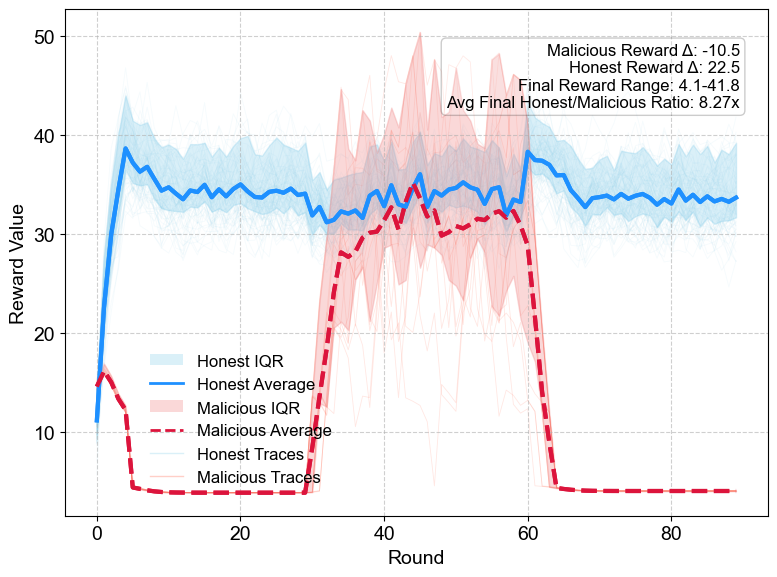


所有模拟和报告生成完毕。


In [31]:
N =100
CS = 5
Phase = 1
Base = 1200
rep_exponent = 0.5
stake_weight = 0.4
R = 90
# ================== Main Program ==================
if __name__ == "__main__":
    # Set fixed random seed for reproducibility
    np.random.seed(1411758002)
    import random
    random.seed(1411758002)
    
    
    # Initialize FL Systems with different malicious ratios
    systems = {
        # "with_malicious_0p10": FLSystem(
        #     num_nodes=N,
        #     base_reward=Base,
        #     committee_size=CS,  # Desired committee size
        #     stake_weight=stake_weight,
        #     rep_exponent= rep_exponent,
        #     malicious_ratio=0.1,  # 10% malicious nodes
        #     phase_switch_round=Phase,
        #     # Sybil resistance not considered
        # ),
        "with_malicious_0p15": FLSystem(
            num_nodes=N,
            base_reward=Base,
            committee_size=CS,  # Desired committee size
            stake_weight=stake_weight,
            rep_exponent=rep_exponent,
            malicious_ratio=0.15,  # 15% malicious nodes
            phase_switch_round=Phase,
            # sybil_resistance=False  # Sybil resistance not considered
        ),
        # "with_malicious_0p20": FLSystem(
        #     num_nodes=N,
        #     base_reward=Base,
        #     committee_size=CS,  # Desired committee size
        #     stake_weight=stake_weight,
        #     rep_exponent=rep_exponent,
        #     malicious_ratio=0.2,  # 20% malicious nodes
        #     phase_switch_round=Phase,
        #     # sybil_resistance=False  # Sybil resistance not considered
        # ),
        # "with_malicious_0p25": FLSystem(
        #     num_nodes=N,
        #     base_reward=Base,
        #     committee_size=CS,  # Desired committee size
        #     stake_weight=stake_weight,
        #     rep_exponent=rep_exponent,
        #     malicious_ratio=0.25,  # 25% malicious nodes
        #     phase_switch_round=Phase,
        #     # sybil_resistance=False  # Sybil resistance not considered
        # ),
        # "with_malicious_0p30": FLSystem(
        #     num_nodes=N,
        #     base_reward=Base,
        #     committee_size=CS,  # Desired committee size
        #     stake_weight=stake_weight,
        #     rep_exponent=rep_exponent,
        #     malicious_ratio=0.3,  # 30% malicious nodes
        #     phase_switch_round=Phase,
            # sybil_resistance=False  # Sybil resistance not considered
        # ),
        # "without_malicious": FLSystem(
        #     num_nodes=N,
        #     base_reward=Base,
        #     committee_size=CS,
        #     stake_weight=stake_weight,
        #     rep_exponent=rep_exponent,
        #     malicious_ratio=0.0,  # No malicious nodes
        #     phase_switch_round=30,
        #     # sybil_resistance=False
        # )
    }
    
    # Define the number of rounds for simulations
    rounds_with_malicious = R
    rounds_without_malicious = R

    # Run Simulations for systems with malicious nodes
    print("开始运行包含恶意节点的模拟...")
    # for _ in tqdm(range(rounds_with_malicious), desc="包含恶意节点"):
    #     for key in ["with_malicious_0p10", "with_malicious_0p15", "with_malicious_0p20", "with_malicious_0p25", "with_malicious_0p30"]:
    #         systems[key].run_round()
    for _ in tqdm(range(rounds_with_malicious), desc="包含恶意节点"):
        for key in ["with_malicious_0p15"]:
            systems[key].run_round()
    
    # Run Simulations for system without malicious nodes
    # print("\n开始运行不包含恶意节点的模拟...")
    # for _ in tqdm(range(rounds_without_malicious), desc="不包含恶意节点"):
    #     systems["without_malicious"].run_round()
    
    # Generate Reports
    folderpath = f"./exp_res/phase{Phase}/"
    print("\n生成模拟报告...")
    for key in systems:
        filename = f"{folderpath}simulation_report_N{N}_{key}.csv"
        generate_simulation_report(systems[key], filename=filename)
    
    # Verify Committee Sizes
    def verify_committee_size(system, expected_size=CS):
        """
        Verify that each committee in the history meets the expected size.
        """
        for round_num, committee in enumerate(system.committee_history, 1):
            if len(committee) != expected_size:
                print(f"Round {round_num}: Committee size {len(committee)} does not match expected {expected_size}.")
        print("Verification complete.")
    
    # Verify committee sizes for all systems
    print("\n验证所有系统的委员会规模...")
    for key in systems:
        print(f"\n验证系统 '{key}' 的委员会规模...")
        verify_committee_size(systems[key], expected_size=CS)
    
    # Generate Visualization for each system
    print("\n生成系统的可视化分析图表...")
    for key in systems:
        print(key)
        label = "With Malicious Nodes" if "with_malicious" in key else "Without Malicious Nodes"
        print(f"生成系统 '{key}' 的图表...")
        plot_metrics(systems[key], label=key)
    
    print("\n所有模拟和报告生成完毕。")


开始运行包含恶意节点的模拟...


包含恶意节点: 100%|██████████| 90/90 [00:02<00:00, 37.34it/s]



生成模拟报告...
Round metrics saved to ./exp_res/phase5/simulation_report_N100_with_malicious_0p15_round_metrics.csv
Node summary metrics saved to ./exp_res/phase5/simulation_report_N100_with_malicious_0p15_node_summary.csv

验证所有系统的委员会规模...

验证系统 'with_malicious_0p15' 的委员会规模...
Verification complete.

生成系统的可视化分析图表...
with_malicious_0p15
生成系统 'with_malicious_0p15' 的图表...


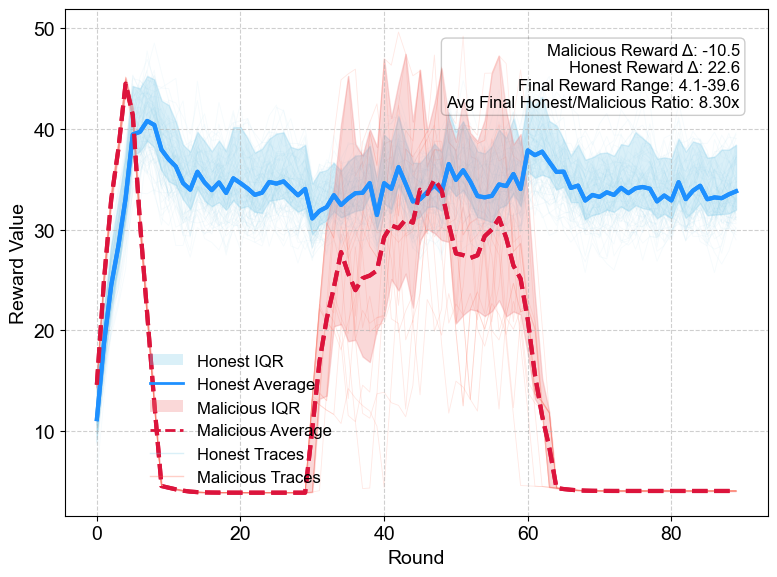


所有模拟和报告生成完毕。


In [32]:
N =100
CS = 5
Phase = 5
Base = 1200
rep_exponent = 0.5
stake_weight = 0.4
R = 90
# ================== Main Program ==================
if __name__ == "__main__":
    # Set fixed random seed for reproducibility
    np.random.seed(1411758002)
    import random
    random.seed(1411758002)
    
    
    # Initialize FL Systems with different malicious ratios
    systems = {
        # "with_malicious_0p10": FLSystem(
        #     num_nodes=N,
        #     base_reward=Base,
        #     committee_size=CS,  # Desired committee size
        #     stake_weight=stake_weight,
        #     rep_exponent= rep_exponent,
        #     malicious_ratio=0.1,  # 10% malicious nodes
        #     phase_switch_round=Phase,
        #     # Sybil resistance not considered
        # ),
        "with_malicious_0p15": FLSystem(
            num_nodes=N,
            base_reward=Base,
            committee_size=CS,  # Desired committee size
            stake_weight=stake_weight,
            rep_exponent=rep_exponent,
            malicious_ratio=0.15,  # 15% malicious nodes
            phase_switch_round=Phase,
            # sybil_resistance=False  # Sybil resistance not considered
        ),
        # "with_malicious_0p20": FLSystem(
        #     num_nodes=N,
        #     base_reward=Base,
        #     committee_size=CS,  # Desired committee size
        #     stake_weight=stake_weight,
        #     rep_exponent=rep_exponent,
        #     malicious_ratio=0.2,  # 20% malicious nodes
        #     phase_switch_round=Phase,
        #     # sybil_resistance=False  # Sybil resistance not considered
        # ),
        # "with_malicious_0p25": FLSystem(
        #     num_nodes=N,
        #     base_reward=Base,
        #     committee_size=CS,  # Desired committee size
        #     stake_weight=stake_weight,
        #     rep_exponent=rep_exponent,
        #     malicious_ratio=0.25,  # 25% malicious nodes
        #     phase_switch_round=Phase,
        #     # sybil_resistance=False  # Sybil resistance not considered
        # ),
        # "with_malicious_0p30": FLSystem(
        #     num_nodes=N,
        #     base_reward=Base,
        #     committee_size=CS,  # Desired committee size
        #     stake_weight=stake_weight,
        #     rep_exponent=rep_exponent,
        #     malicious_ratio=0.3,  # 30% malicious nodes
        #     phase_switch_round=Phase,
            # sybil_resistance=False  # Sybil resistance not considered
        # ),
        # "without_malicious": FLSystem(
        #     num_nodes=N,
        #     base_reward=Base,
        #     committee_size=CS,
        #     stake_weight=stake_weight,
        #     rep_exponent=rep_exponent,
        #     malicious_ratio=0.0,  # No malicious nodes
        #     phase_switch_round=30,
        #     # sybil_resistance=False
        # )
    }
    
    # Define the number of rounds for simulations
    rounds_with_malicious = R
    rounds_without_malicious = R

    # Run Simulations for systems with malicious nodes
    print("开始运行包含恶意节点的模拟...")
    # for _ in tqdm(range(rounds_with_malicious), desc="包含恶意节点"):
    #     for key in ["with_malicious_0p10", "with_malicious_0p15", "with_malicious_0p20", "with_malicious_0p25", "with_malicious_0p30"]:
    #         systems[key].run_round()
    for _ in tqdm(range(rounds_with_malicious), desc="包含恶意节点"):
        for key in ["with_malicious_0p15"]:
            systems[key].run_round()
    
    # Run Simulations for system without malicious nodes
    # print("\n开始运行不包含恶意节点的模拟...")
    # for _ in tqdm(range(rounds_without_malicious), desc="不包含恶意节点"):
    #     systems["without_malicious"].run_round()
    
    # Generate Reports
    folderpath = f"./exp_res/phase{Phase}/"
    print("\n生成模拟报告...")
    for key in systems:
        filename = f"{folderpath}simulation_report_N{N}_{key}.csv"
        generate_simulation_report(systems[key], filename=filename)
    
    # Verify Committee Sizes
    def verify_committee_size(system, expected_size=CS):
        """
        Verify that each committee in the history meets the expected size.
        """
        for round_num, committee in enumerate(system.committee_history, 1):
            if len(committee) != expected_size:
                print(f"Round {round_num}: Committee size {len(committee)} does not match expected {expected_size}.")
        print("Verification complete.")
    
    # Verify committee sizes for all systems
    print("\n验证所有系统的委员会规模...")
    for key in systems:
        print(f"\n验证系统 '{key}' 的委员会规模...")
        verify_committee_size(systems[key], expected_size=CS)
    
    # Generate Visualization for each system
    print("\n生成系统的可视化分析图表...")
    for key in systems:
        print(key)
        label = "With Malicious Nodes" if "with_malicious" in key else "Without Malicious Nodes"
        print(f"生成系统 '{key}' 的图表...")
        plot_metrics(systems[key], label=key)
    
    print("\n所有模拟和报告生成完毕。")


开始运行包含恶意节点的模拟...


包含恶意节点: 100%|██████████| 90/90 [00:02<00:00, 39.37it/s]



生成模拟报告...
Round metrics saved to ./exp_res/phase10/simulation_report_N100_with_malicious_0p15_round_metrics.csv
Node summary metrics saved to ./exp_res/phase10/simulation_report_N100_with_malicious_0p15_node_summary.csv

验证所有系统的委员会规模...

验证系统 'with_malicious_0p15' 的委员会规模...
Verification complete.

生成系统的可视化分析图表...
with_malicious_0p15
生成系统 'with_malicious_0p15' 的图表...


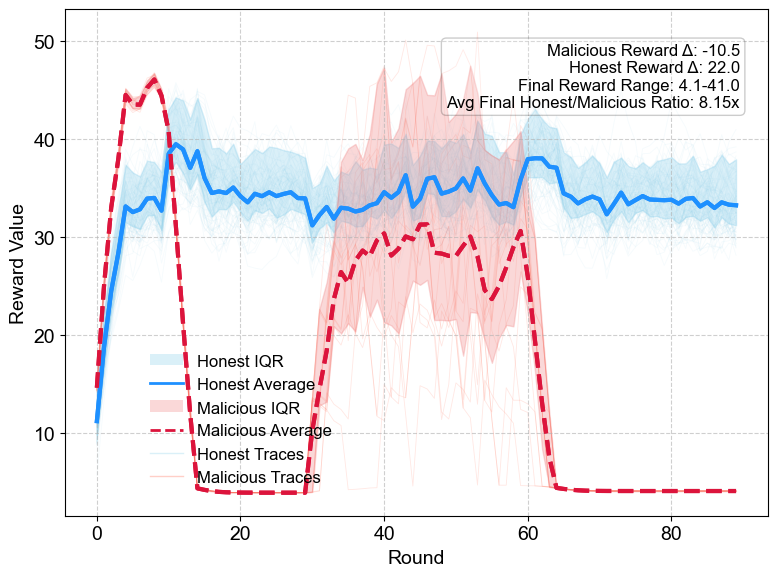


所有模拟和报告生成完毕。


In [33]:
N =100
CS = 5
Phase = 10
Base = 1200
rep_exponent = 0.5
stake_weight = 0.4
R = 90
# ================== Main Program ==================
if __name__ == "__main__":
    # Set fixed random seed for reproducibility
    np.random.seed(1411758002)
    import random
    random.seed(1411758002)
    
    
    # Initialize FL Systems with different malicious ratios
    systems = {
        # "with_malicious_0p10": FLSystem(
        #     num_nodes=N,
        #     base_reward=Base,
        #     committee_size=CS,  # Desired committee size
        #     stake_weight=stake_weight,
        #     rep_exponent= rep_exponent,
        #     malicious_ratio=0.1,  # 10% malicious nodes
        #     phase_switch_round=Phase,
        #     # Sybil resistance not considered
        # ),
        "with_malicious_0p15": FLSystem(
            num_nodes=N,
            base_reward=Base,
            committee_size=CS,  # Desired committee size
            stake_weight=stake_weight,
            rep_exponent=rep_exponent,
            malicious_ratio=0.15,  # 15% malicious nodes
            phase_switch_round=Phase,
            # sybil_resistance=False  # Sybil resistance not considered
        ),
        # "with_malicious_0p20": FLSystem(
        #     num_nodes=N,
        #     base_reward=Base,
        #     committee_size=CS,  # Desired committee size
        #     stake_weight=stake_weight,
        #     rep_exponent=rep_exponent,
        #     malicious_ratio=0.2,  # 20% malicious nodes
        #     phase_switch_round=Phase,
        #     # sybil_resistance=False  # Sybil resistance not considered
        # ),
        # "with_malicious_0p25": FLSystem(
        #     num_nodes=N,
        #     base_reward=Base,
        #     committee_size=CS,  # Desired committee size
        #     stake_weight=stake_weight,
        #     rep_exponent=rep_exponent,
        #     malicious_ratio=0.25,  # 25% malicious nodes
        #     phase_switch_round=Phase,
        #     # sybil_resistance=False  # Sybil resistance not considered
        # ),
        # "with_malicious_0p30": FLSystem(
        #     num_nodes=N,
        #     base_reward=Base,
        #     committee_size=CS,  # Desired committee size
        #     stake_weight=stake_weight,
        #     rep_exponent=rep_exponent,
        #     malicious_ratio=0.3,  # 30% malicious nodes
        #     phase_switch_round=Phase,
            # sybil_resistance=False  # Sybil resistance not considered
        # ),
        # "without_malicious": FLSystem(
        #     num_nodes=N,
        #     base_reward=Base,
        #     committee_size=CS,
        #     stake_weight=stake_weight,
        #     rep_exponent=rep_exponent,
        #     malicious_ratio=0.0,  # No malicious nodes
        #     phase_switch_round=30,
        #     # sybil_resistance=False
        # )
    }
    
    # Define the number of rounds for simulations
    rounds_with_malicious = R
    rounds_without_malicious = R

    # Run Simulations for systems with malicious nodes
    print("开始运行包含恶意节点的模拟...")
    # for _ in tqdm(range(rounds_with_malicious), desc="包含恶意节点"):
    #     for key in ["with_malicious_0p10", "with_malicious_0p15", "with_malicious_0p20", "with_malicious_0p25", "with_malicious_0p30"]:
    #         systems[key].run_round()
    for _ in tqdm(range(rounds_with_malicious), desc="包含恶意节点"):
        for key in ["with_malicious_0p15"]:
            systems[key].run_round()
    
    # Run Simulations for system without malicious nodes
    # print("\n开始运行不包含恶意节点的模拟...")
    # for _ in tqdm(range(rounds_without_malicious), desc="不包含恶意节点"):
    #     systems["without_malicious"].run_round()
    
    # Generate Reports
    folderpath = f"./exp_res/phase{Phase}/"
    print("\n生成模拟报告...")
    for key in systems:
        filename = f"{folderpath}simulation_report_N{N}_{key}.csv"
        generate_simulation_report(systems[key], filename=filename)
    
    # Verify Committee Sizes
    def verify_committee_size(system, expected_size=CS):
        """
        Verify that each committee in the history meets the expected size.
        """
        for round_num, committee in enumerate(system.committee_history, 1):
            if len(committee) != expected_size:
                print(f"Round {round_num}: Committee size {len(committee)} does not match expected {expected_size}.")
        print("Verification complete.")
    
    # Verify committee sizes for all systems
    print("\n验证所有系统的委员会规模...")
    for key in systems:
        print(f"\n验证系统 '{key}' 的委员会规模...")
        verify_committee_size(systems[key], expected_size=CS)
    
    # Generate Visualization for each system
    print("\n生成系统的可视化分析图表...")
    for key in systems:
        print(key)
        label = "With Malicious Nodes" if "with_malicious" in key else "Without Malicious Nodes"
        print(f"生成系统 '{key}' 的图表...")
        plot_metrics(systems[key], label=key)
    
    print("\n所有模拟和报告生成完毕。")


开始运行包含恶意节点的模拟...


包含恶意节点: 100%|██████████| 90/90 [00:02<00:00, 39.87it/s]



生成模拟报告...
Round metrics saved to ./exp_res/phase15/simulation_report_N100_with_malicious_0p15_round_metrics.csv
Node summary metrics saved to ./exp_res/phase15/simulation_report_N100_with_malicious_0p15_node_summary.csv

验证所有系统的委员会规模...

验证系统 'with_malicious_0p15' 的委员会规模...
Verification complete.

生成系统的可视化分析图表...
with_malicious_0p15
生成系统 'with_malicious_0p15' 的图表...


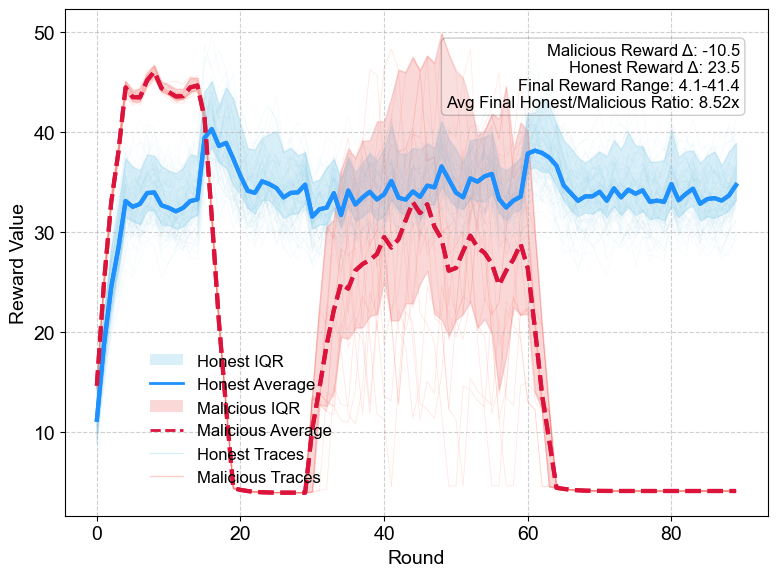


所有模拟和报告生成完毕。


In [34]:
N =100
CS = 5
Phase = 15
Base = 1200
rep_exponent = 0.5
stake_weight = 0.4
R = 90
# ================== Main Program ==================
if __name__ == "__main__":
    # Set fixed random seed for reproducibility
    np.random.seed(1411758002)
    import random
    random.seed(1411758002)
    
    
    # Initialize FL Systems with different malicious ratios
    systems = {
        # "with_malicious_0p10": FLSystem(
        #     num_nodes=N,
        #     base_reward=Base,
        #     committee_size=CS,  # Desired committee size
        #     stake_weight=stake_weight,
        #     rep_exponent= rep_exponent,
        #     malicious_ratio=0.1,  # 10% malicious nodes
        #     phase_switch_round=Phase,
        #     # Sybil resistance not considered
        # ),
        "with_malicious_0p15": FLSystem(
            num_nodes=N,
            base_reward=Base,
            committee_size=CS,  # Desired committee size
            stake_weight=stake_weight,
            rep_exponent=rep_exponent,
            malicious_ratio=0.15,  # 15% malicious nodes
            phase_switch_round=Phase,
            # sybil_resistance=False  # Sybil resistance not considered
        ),
        # "with_malicious_0p20": FLSystem(
        #     num_nodes=N,
        #     base_reward=Base,
        #     committee_size=CS,  # Desired committee size
        #     stake_weight=stake_weight,
        #     rep_exponent=rep_exponent,
        #     malicious_ratio=0.2,  # 20% malicious nodes
        #     phase_switch_round=Phase,
        #     # sybil_resistance=False  # Sybil resistance not considered
        # ),
        # "with_malicious_0p25": FLSystem(
        #     num_nodes=N,
        #     base_reward=Base,
        #     committee_size=CS,  # Desired committee size
        #     stake_weight=stake_weight,
        #     rep_exponent=rep_exponent,
        #     malicious_ratio=0.25,  # 25% malicious nodes
        #     phase_switch_round=Phase,
        #     # sybil_resistance=False  # Sybil resistance not considered
        # ),
        # "with_malicious_0p30": FLSystem(
        #     num_nodes=N,
        #     base_reward=Base,
        #     committee_size=CS,  # Desired committee size
        #     stake_weight=stake_weight,
        #     rep_exponent=rep_exponent,
        #     malicious_ratio=0.3,  # 30% malicious nodes
        #     phase_switch_round=Phase,
            # sybil_resistance=False  # Sybil resistance not considered
        # ),
        # "without_malicious": FLSystem(
        #     num_nodes=N,
        #     base_reward=Base,
        #     committee_size=CS,
        #     stake_weight=stake_weight,
        #     rep_exponent=rep_exponent,
        #     malicious_ratio=0.0,  # No malicious nodes
        #     phase_switch_round=30,
        #     # sybil_resistance=False
        # )
    }
    
    # Define the number of rounds for simulations
    rounds_with_malicious = R
    rounds_without_malicious = R

    # Run Simulations for systems with malicious nodes
    print("开始运行包含恶意节点的模拟...")
    # for _ in tqdm(range(rounds_with_malicious), desc="包含恶意节点"):
    #     for key in ["with_malicious_0p10", "with_malicious_0p15", "with_malicious_0p20", "with_malicious_0p25", "with_malicious_0p30"]:
    #         systems[key].run_round()
    for _ in tqdm(range(rounds_with_malicious), desc="包含恶意节点"):
        for key in ["with_malicious_0p15"]:
            systems[key].run_round()
    
    # Run Simulations for system without malicious nodes
    # print("\n开始运行不包含恶意节点的模拟...")
    # for _ in tqdm(range(rounds_without_malicious), desc="不包含恶意节点"):
    #     systems["without_malicious"].run_round()
    
    # Generate Reports
    folderpath = f"./exp_res/phase{Phase}/"
    print("\n生成模拟报告...")
    for key in systems:
        filename = f"{folderpath}simulation_report_N{N}_{key}.csv"
        generate_simulation_report(systems[key], filename=filename)
    
    # Verify Committee Sizes
    def verify_committee_size(system, expected_size=CS):
        """
        Verify that each committee in the history meets the expected size.
        """
        for round_num, committee in enumerate(system.committee_history, 1):
            if len(committee) != expected_size:
                print(f"Round {round_num}: Committee size {len(committee)} does not match expected {expected_size}.")
        print("Verification complete.")
    
    # Verify committee sizes for all systems
    print("\n验证所有系统的委员会规模...")
    for key in systems:
        print(f"\n验证系统 '{key}' 的委员会规模...")
        verify_committee_size(systems[key], expected_size=CS)
    
    # Generate Visualization for each system
    print("\n生成系统的可视化分析图表...")
    for key in systems:
        print(key)
        label = "With Malicious Nodes" if "with_malicious" in key else "Without Malicious Nodes"
        print(f"生成系统 '{key}' 的图表...")
        plot_metrics(systems[key], label=key)
    
    print("\n所有模拟和报告生成完毕。")


开始运行包含恶意节点的模拟...


包含恶意节点: 100%|██████████| 90/90 [00:02<00:00, 39.18it/s]



生成模拟报告...
Round metrics saved to ./exp_res/phase20/simulation_report_N100_with_malicious_0p15_round_metrics.csv
Node summary metrics saved to ./exp_res/phase20/simulation_report_N100_with_malicious_0p15_node_summary.csv

验证所有系统的委员会规模...

验证系统 'with_malicious_0p15' 的委员会规模...
Verification complete.

生成系统的可视化分析图表...
with_malicious_0p15
生成系统 'with_malicious_0p15' 的图表...


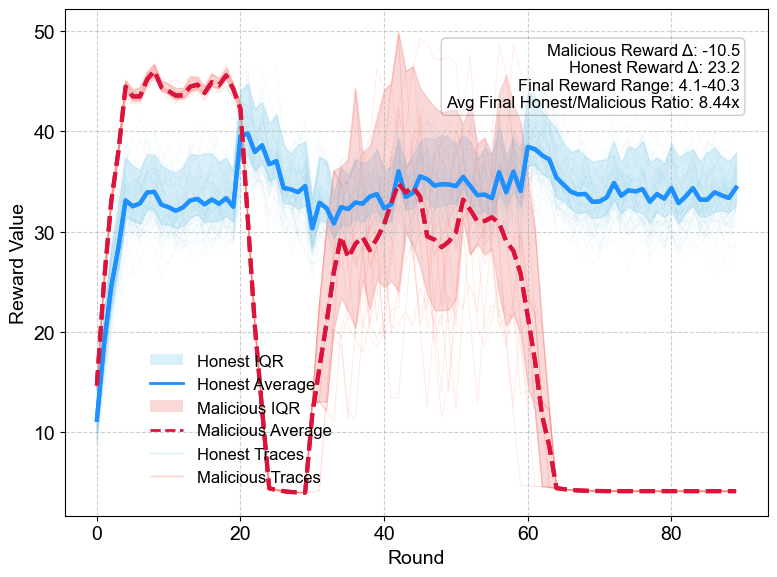


所有模拟和报告生成完毕。


In [35]:
N =100
CS = 5
Phase = 20
Base = 1200
rep_exponent = 0.5
stake_weight = 0.4
R = 90
# ================== Main Program ==================
if __name__ == "__main__":
    # Set fixed random seed for reproducibility
    np.random.seed(1411758002)
    import random
    random.seed(1411758002)
    
    
    # Initialize FL Systems with different malicious ratios
    systems = {
        # "with_malicious_0p10": FLSystem(
        #     num_nodes=N,
        #     base_reward=Base,
        #     committee_size=CS,  # Desired committee size
        #     stake_weight=stake_weight,
        #     rep_exponent= rep_exponent,
        #     malicious_ratio=0.1,  # 10% malicious nodes
        #     phase_switch_round=Phase,
        #     # Sybil resistance not considered
        # ),
        "with_malicious_0p15": FLSystem(
            num_nodes=N,
            base_reward=Base,
            committee_size=CS,  # Desired committee size
            stake_weight=stake_weight,
            rep_exponent=rep_exponent,
            malicious_ratio=0.15,  # 15% malicious nodes
            phase_switch_round=Phase,
            # sybil_resistance=False  # Sybil resistance not considered
        ),
        # "with_malicious_0p20": FLSystem(
        #     num_nodes=N,
        #     base_reward=Base,
        #     committee_size=CS,  # Desired committee size
        #     stake_weight=stake_weight,
        #     rep_exponent=rep_exponent,
        #     malicious_ratio=0.2,  # 20% malicious nodes
        #     phase_switch_round=Phase,
        #     # sybil_resistance=False  # Sybil resistance not considered
        # ),
        # "with_malicious_0p25": FLSystem(
        #     num_nodes=N,
        #     base_reward=Base,
        #     committee_size=CS,  # Desired committee size
        #     stake_weight=stake_weight,
        #     rep_exponent=rep_exponent,
        #     malicious_ratio=0.25,  # 25% malicious nodes
        #     phase_switch_round=Phase,
        #     # sybil_resistance=False  # Sybil resistance not considered
        # ),
        # "with_malicious_0p30": FLSystem(
        #     num_nodes=N,
        #     base_reward=Base,
        #     committee_size=CS,  # Desired committee size
        #     stake_weight=stake_weight,
        #     rep_exponent=rep_exponent,
        #     malicious_ratio=0.3,  # 30% malicious nodes
        #     phase_switch_round=Phase,
            # sybil_resistance=False  # Sybil resistance not considered
        # ),
        # "without_malicious": FLSystem(
        #     num_nodes=N,
        #     base_reward=Base,
        #     committee_size=CS,
        #     stake_weight=stake_weight,
        #     rep_exponent=rep_exponent,
        #     malicious_ratio=0.0,  # No malicious nodes
        #     phase_switch_round=30,
        #     # sybil_resistance=False
        # )
    }
    
    # Define the number of rounds for simulations
    rounds_with_malicious = R
    rounds_without_malicious = R

    # Run Simulations for systems with malicious nodes
    print("开始运行包含恶意节点的模拟...")
    # for _ in tqdm(range(rounds_with_malicious), desc="包含恶意节点"):
    #     for key in ["with_malicious_0p10", "with_malicious_0p15", "with_malicious_0p20", "with_malicious_0p25", "with_malicious_0p30"]:
    #         systems[key].run_round()
    for _ in tqdm(range(rounds_with_malicious), desc="包含恶意节点"):
        for key in ["with_malicious_0p15"]:
            systems[key].run_round()
    
    # Run Simulations for system without malicious nodes
    # print("\n开始运行不包含恶意节点的模拟...")
    # for _ in tqdm(range(rounds_without_malicious), desc="不包含恶意节点"):
    #     systems["without_malicious"].run_round()
    
    # Generate Reports
    folderpath = f"./exp_res/phase{Phase}/"
    print("\n生成模拟报告...")
    for key in systems:
        filename = f"{folderpath}simulation_report_N{N}_{key}.csv"
        generate_simulation_report(systems[key], filename=filename)
    
    # Verify Committee Sizes
    def verify_committee_size(system, expected_size=CS):
        """
        Verify that each committee in the history meets the expected size.
        """
        for round_num, committee in enumerate(system.committee_history, 1):
            if len(committee) != expected_size:
                print(f"Round {round_num}: Committee size {len(committee)} does not match expected {expected_size}.")
        print("Verification complete.")
    
    # Verify committee sizes for all systems
    print("\n验证所有系统的委员会规模...")
    for key in systems:
        print(f"\n验证系统 '{key}' 的委员会规模...")
        verify_committee_size(systems[key], expected_size=CS)
    
    # Generate Visualization for each system
    print("\n生成系统的可视化分析图表...")
    for key in systems:
        print(key)
        label = "With Malicious Nodes" if "with_malicious" in key else "Without Malicious Nodes"
        print(f"生成系统 '{key}' 的图表...")
        plot_metrics(systems[key], label=key)
    
    print("\n所有模拟和报告生成完毕。")


开始运行包含恶意节点的模拟...


包含恶意节点: 100%|██████████| 90/90 [00:02<00:00, 39.86it/s]



生成模拟报告...
Round metrics saved to ./exp_res/phase25/simulation_report_N100_with_malicious_0p15_round_metrics.csv
Node summary metrics saved to ./exp_res/phase25/simulation_report_N100_with_malicious_0p15_node_summary.csv

验证所有系统的委员会规模...

验证系统 'with_malicious_0p15' 的委员会规模...
Verification complete.

生成系统的可视化分析图表...
with_malicious_0p15
生成系统 'with_malicious_0p15' 的图表...


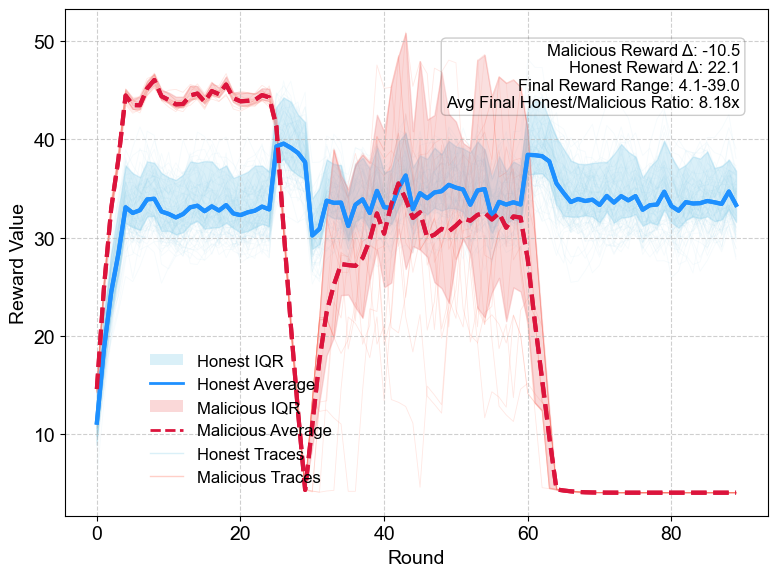


所有模拟和报告生成完毕。


In [36]:
N =100
CS = 5
Phase = 25
Base = 1200
rep_exponent = 0.5
stake_weight = 0.4
R = 90
# ================== Main Program ==================
if __name__ == "__main__":
    # Set fixed random seed for reproducibility
    np.random.seed(1411758002)
    import random
    random.seed(1411758002)
    
    
    # Initialize FL Systems with different malicious ratios
    systems = {
        # "with_malicious_0p10": FLSystem(
        #     num_nodes=N,
        #     base_reward=Base,
        #     committee_size=CS,  # Desired committee size
        #     stake_weight=stake_weight,
        #     rep_exponent= rep_exponent,
        #     malicious_ratio=0.1,  # 10% malicious nodes
        #     phase_switch_round=Phase,
        #     # Sybil resistance not considered
        # ),
        "with_malicious_0p15": FLSystem(
            num_nodes=N,
            base_reward=Base,
            committee_size=CS,  # Desired committee size
            stake_weight=stake_weight,
            rep_exponent=rep_exponent,
            malicious_ratio=0.15,  # 15% malicious nodes
            phase_switch_round=Phase,
            # sybil_resistance=False  # Sybil resistance not considered
        ),
        # "with_malicious_0p20": FLSystem(
        #     num_nodes=N,
        #     base_reward=Base,
        #     committee_size=CS,  # Desired committee size
        #     stake_weight=stake_weight,
        #     rep_exponent=rep_exponent,
        #     malicious_ratio=0.2,  # 20% malicious nodes
        #     phase_switch_round=Phase,
        #     # sybil_resistance=False  # Sybil resistance not considered
        # ),
        # "with_malicious_0p25": FLSystem(
        #     num_nodes=N,
        #     base_reward=Base,
        #     committee_size=CS,  # Desired committee size
        #     stake_weight=stake_weight,
        #     rep_exponent=rep_exponent,
        #     malicious_ratio=0.25,  # 25% malicious nodes
        #     phase_switch_round=Phase,
        #     # sybil_resistance=False  # Sybil resistance not considered
        # ),
        # "with_malicious_0p30": FLSystem(
        #     num_nodes=N,
        #     base_reward=Base,
        #     committee_size=CS,  # Desired committee size
        #     stake_weight=stake_weight,
        #     rep_exponent=rep_exponent,
        #     malicious_ratio=0.3,  # 30% malicious nodes
        #     phase_switch_round=Phase,
            # sybil_resistance=False  # Sybil resistance not considered
        # ),
        # "without_malicious": FLSystem(
        #     num_nodes=N,
        #     base_reward=Base,
        #     committee_size=CS,
        #     stake_weight=stake_weight,
        #     rep_exponent=rep_exponent,
        #     malicious_ratio=0.0,  # No malicious nodes
        #     phase_switch_round=30,
        #     # sybil_resistance=False
        # )
    }
    
    # Define the number of rounds for simulations
    rounds_with_malicious = R
    rounds_without_malicious = R

    # Run Simulations for systems with malicious nodes
    print("开始运行包含恶意节点的模拟...")
    # for _ in tqdm(range(rounds_with_malicious), desc="包含恶意节点"):
    #     for key in ["with_malicious_0p10", "with_malicious_0p15", "with_malicious_0p20", "with_malicious_0p25", "with_malicious_0p30"]:
    #         systems[key].run_round()
    for _ in tqdm(range(rounds_with_malicious), desc="包含恶意节点"):
        for key in ["with_malicious_0p15"]:
            systems[key].run_round()
    
    # Run Simulations for system without malicious nodes
    # print("\n开始运行不包含恶意节点的模拟...")
    # for _ in tqdm(range(rounds_without_malicious), desc="不包含恶意节点"):
    #     systems["without_malicious"].run_round()
    
    # Generate Reports
    folderpath = f"./exp_res/phase{Phase}/"
    print("\n生成模拟报告...")
    for key in systems:
        filename = f"{folderpath}simulation_report_N{N}_{key}.csv"
        generate_simulation_report(systems[key], filename=filename)
    
    # Verify Committee Sizes
    def verify_committee_size(system, expected_size=CS):
        """
        Verify that each committee in the history meets the expected size.
        """
        for round_num, committee in enumerate(system.committee_history, 1):
            if len(committee) != expected_size:
                print(f"Round {round_num}: Committee size {len(committee)} does not match expected {expected_size}.")
        print("Verification complete.")
    
    # Verify committee sizes for all systems
    print("\n验证所有系统的委员会规模...")
    for key in systems:
        print(f"\n验证系统 '{key}' 的委员会规模...")
        verify_committee_size(systems[key], expected_size=CS)
    
    # Generate Visualization for each system
    print("\n生成系统的可视化分析图表...")
    for key in systems:
        print(key)
        label = "With Malicious Nodes" if "with_malicious" in key else "Without Malicious Nodes"
        print(f"生成系统 '{key}' 的图表...")
        plot_metrics(systems[key], label=key)
    
    print("\n所有模拟和报告生成完毕。")


开始运行包含恶意节点的模拟...


包含恶意节点: 100%|██████████| 90/90 [00:02<00:00, 38.08it/s]



生成模拟报告...
Round metrics saved to ./exp_res/phase30/simulation_report_N100_with_malicious_0p15_round_metrics.csv
Node summary metrics saved to ./exp_res/phase30/simulation_report_N100_with_malicious_0p15_node_summary.csv

验证所有系统的委员会规模...

验证系统 'with_malicious_0p15' 的委员会规模...
Verification complete.

生成系统的可视化分析图表...
with_malicious_0p15
生成系统 'with_malicious_0p15' 的图表...


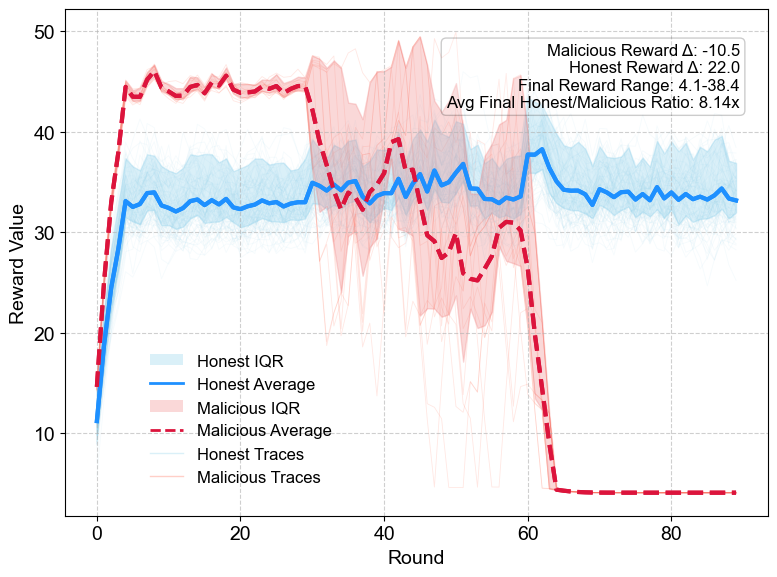


所有模拟和报告生成完毕。


In [37]:
N =100
CS = 5
Phase = 30
Base = 1200
rep_exponent = 0.5
stake_weight = 0.4
R = 90
# ================== Main Program ==================
if __name__ == "__main__":
    # Set fixed random seed for reproducibility
    np.random.seed(1411758002)
    import random
    random.seed(1411758002)
    
    
    # Initialize FL Systems with different malicious ratios
    systems = {
        # "with_malicious_0p10": FLSystem(
        #     num_nodes=N,
        #     base_reward=Base,
        #     committee_size=CS,  # Desired committee size
        #     stake_weight=stake_weight,
        #     rep_exponent= rep_exponent,
        #     malicious_ratio=0.1,  # 10% malicious nodes
        #     phase_switch_round=Phase,
        #     # Sybil resistance not considered
        # ),
        "with_malicious_0p15": FLSystem(
            num_nodes=N,
            base_reward=Base,
            committee_size=CS,  # Desired committee size
            stake_weight=stake_weight,
            rep_exponent=rep_exponent,
            malicious_ratio=0.15,  # 15% malicious nodes
            phase_switch_round=Phase,
            # sybil_resistance=False  # Sybil resistance not considered
        ),
        # "with_malicious_0p20": FLSystem(
        #     num_nodes=N,
        #     base_reward=Base,
        #     committee_size=CS,  # Desired committee size
        #     stake_weight=stake_weight,
        #     rep_exponent=rep_exponent,
        #     malicious_ratio=0.2,  # 20% malicious nodes
        #     phase_switch_round=Phase,
        #     # sybil_resistance=False  # Sybil resistance not considered
        # ),
        # "with_malicious_0p25": FLSystem(
        #     num_nodes=N,
        #     base_reward=Base,
        #     committee_size=CS,  # Desired committee size
        #     stake_weight=stake_weight,
        #     rep_exponent=rep_exponent,
        #     malicious_ratio=0.25,  # 25% malicious nodes
        #     phase_switch_round=Phase,
        #     # sybil_resistance=False  # Sybil resistance not considered
        # ),
        # "with_malicious_0p30": FLSystem(
        #     num_nodes=N,
        #     base_reward=Base,
        #     committee_size=CS,  # Desired committee size
        #     stake_weight=stake_weight,
        #     rep_exponent=rep_exponent,
        #     malicious_ratio=0.3,  # 30% malicious nodes
        #     phase_switch_round=Phase,
            # sybil_resistance=False  # Sybil resistance not considered
        # ),
        # "without_malicious": FLSystem(
        #     num_nodes=N,
        #     base_reward=Base,
        #     committee_size=CS,
        #     stake_weight=stake_weight,
        #     rep_exponent=rep_exponent,
        #     malicious_ratio=0.0,  # No malicious nodes
        #     phase_switch_round=30,
        #     # sybil_resistance=False
        # )
    }
    
    # Define the number of rounds for simulations
    rounds_with_malicious = R
    rounds_without_malicious = R

    # Run Simulations for systems with malicious nodes
    print("开始运行包含恶意节点的模拟...")
    # for _ in tqdm(range(rounds_with_malicious), desc="包含恶意节点"):
    #     for key in ["with_malicious_0p10", "with_malicious_0p15", "with_malicious_0p20", "with_malicious_0p25", "with_malicious_0p30"]:
    #         systems[key].run_round()
    for _ in tqdm(range(rounds_with_malicious), desc="包含恶意节点"):
        for key in ["with_malicious_0p15"]:
            systems[key].run_round()
    
    # Run Simulations for system without malicious nodes
    # print("\n开始运行不包含恶意节点的模拟...")
    # for _ in tqdm(range(rounds_without_malicious), desc="不包含恶意节点"):
    #     systems["without_malicious"].run_round()
    
    # Generate Reports
    folderpath = f"./exp_res/phase{Phase}/"
    print("\n生成模拟报告...")
    for key in systems:
        filename = f"{folderpath}simulation_report_N{N}_{key}.csv"
        generate_simulation_report(systems[key], filename=filename)
    
    # Verify Committee Sizes
    def verify_committee_size(system, expected_size=CS):
        """
        Verify that each committee in the history meets the expected size.
        """
        for round_num, committee in enumerate(system.committee_history, 1):
            if len(committee) != expected_size:
                print(f"Round {round_num}: Committee size {len(committee)} does not match expected {expected_size}.")
        print("Verification complete.")
    
    # Verify committee sizes for all systems
    print("\n验证所有系统的委员会规模...")
    for key in systems:
        print(f"\n验证系统 '{key}' 的委员会规模...")
        verify_committee_size(systems[key], expected_size=CS)
    
    # Generate Visualization for each system
    print("\n生成系统的可视化分析图表...")
    for key in systems:
        print(key)
        label = "With Malicious Nodes" if "with_malicious" in key else "Without Malicious Nodes"
        print(f"生成系统 '{key}' 的图表...")
        plot_metrics(systems[key], label=key)
    
    print("\n所有模拟和报告生成完毕。")


开始运行包含恶意节点的模拟...


包含恶意节点: 100%|██████████| 90/90 [00:02<00:00, 40.44it/s]



生成模拟报告...
Round metrics saved to ./exp_res/phase60/simulation_report_N100_with_malicious_0p15_round_metrics.csv
Node summary metrics saved to ./exp_res/phase60/simulation_report_N100_with_malicious_0p15_node_summary.csv

验证所有系统的委员会规模...

验证系统 'with_malicious_0p15' 的委员会规模...
Verification complete.

生成系统的可视化分析图表...
with_malicious_0p15
生成系统 'with_malicious_0p15' 的图表...


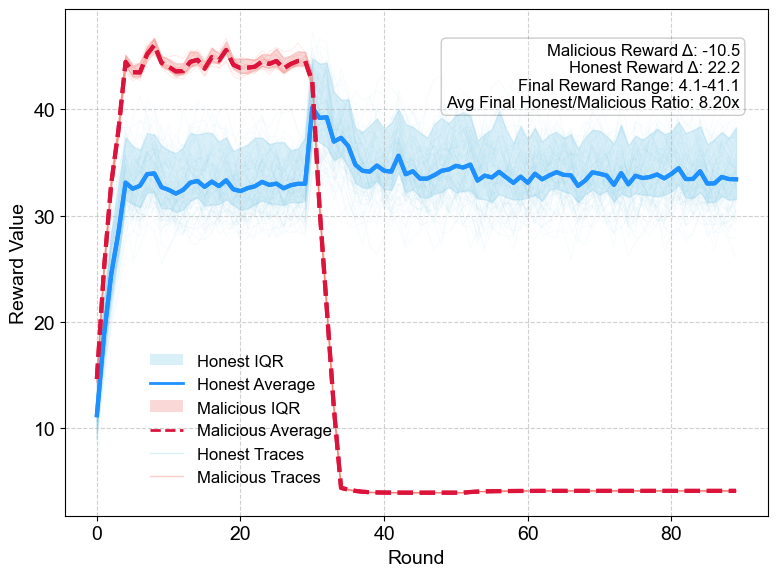


所有模拟和报告生成完毕。


In [38]:
N =100
CS = 5
Phase = 60
Base = 1200
rep_exponent = 0.5
stake_weight = 0.4
R = 90
# ================== Main Program ==================
if __name__ == "__main__":
    # Set fixed random seed for reproducibility
    np.random.seed(1411758002)
    import random
    random.seed(1411758002)
    
    
    # Initialize FL Systems with different malicious ratios
    systems = {
        # "with_malicious_0p10": FLSystem(
        #     num_nodes=N,
        #     base_reward=Base,
        #     committee_size=CS,  # Desired committee size
        #     stake_weight=stake_weight,
        #     rep_exponent= rep_exponent,
        #     malicious_ratio=0.1,  # 10% malicious nodes
        #     phase_switch_round=Phase,
        #     # Sybil resistance not considered
        # ),
        "with_malicious_0p15": FLSystem(
            num_nodes=N,
            base_reward=Base,
            committee_size=CS,  # Desired committee size
            stake_weight=stake_weight,
            rep_exponent=rep_exponent,
            malicious_ratio=0.15,  # 15% malicious nodes
            phase_switch_round=Phase,
            # sybil_resistance=False  # Sybil resistance not considered
        ),
        # "with_malicious_0p20": FLSystem(
        #     num_nodes=N,
        #     base_reward=Base,
        #     committee_size=CS,  # Desired committee size
        #     stake_weight=stake_weight,
        #     rep_exponent=rep_exponent,
        #     malicious_ratio=0.2,  # 20% malicious nodes
        #     phase_switch_round=Phase,
        #     # sybil_resistance=False  # Sybil resistance not considered
        # ),
        # "with_malicious_0p25": FLSystem(
        #     num_nodes=N,
        #     base_reward=Base,
        #     committee_size=CS,  # Desired committee size
        #     stake_weight=stake_weight,
        #     rep_exponent=rep_exponent,
        #     malicious_ratio=0.25,  # 25% malicious nodes
        #     phase_switch_round=Phase,
        #     # sybil_resistance=False  # Sybil resistance not considered
        # ),
        # "with_malicious_0p30": FLSystem(
        #     num_nodes=N,
        #     base_reward=Base,
        #     committee_size=CS,  # Desired committee size
        #     stake_weight=stake_weight,
        #     rep_exponent=rep_exponent,
        #     malicious_ratio=0.3,  # 30% malicious nodes
        #     phase_switch_round=Phase,
            # sybil_resistance=False  # Sybil resistance not considered
        # ),
        # "without_malicious": FLSystem(
        #     num_nodes=N,
        #     base_reward=Base,
        #     committee_size=CS,
        #     stake_weight=stake_weight,
        #     rep_exponent=rep_exponent,
        #     malicious_ratio=0.0,  # No malicious nodes
        #     phase_switch_round=30,
        #     # sybil_resistance=False
        # )
    }
    
    # Define the number of rounds for simulations
    rounds_with_malicious = R
    rounds_without_malicious = R

    # Run Simulations for systems with malicious nodes
    print("开始运行包含恶意节点的模拟...")
    # for _ in tqdm(range(rounds_with_malicious), desc="包含恶意节点"):
    #     for key in ["with_malicious_0p10", "with_malicious_0p15", "with_malicious_0p20", "with_malicious_0p25", "with_malicious_0p30"]:
    #         systems[key].run_round()
    for _ in tqdm(range(rounds_with_malicious), desc="包含恶意节点"):
        for key in ["with_malicious_0p15"]:
            systems[key].run_round()
    
    # Run Simulations for system without malicious nodes
    # print("\n开始运行不包含恶意节点的模拟...")
    # for _ in tqdm(range(rounds_without_malicious), desc="不包含恶意节点"):
    #     systems["without_malicious"].run_round()
    
    # Generate Reports
    folderpath = f"./exp_res/phase{Phase}/"
    print("\n生成模拟报告...")
    for key in systems:
        filename = f"{folderpath}simulation_report_N{N}_{key}.csv"
        generate_simulation_report(systems[key], filename=filename)
    
    # Verify Committee Sizes
    def verify_committee_size(system, expected_size=CS):
        """
        Verify that each committee in the history meets the expected size.
        """
        for round_num, committee in enumerate(system.committee_history, 1):
            if len(committee) != expected_size:
                print(f"Round {round_num}: Committee size {len(committee)} does not match expected {expected_size}.")
        print("Verification complete.")
    
    # Verify committee sizes for all systems
    print("\n验证所有系统的委员会规模...")
    for key in systems:
        print(f"\n验证系统 '{key}' 的委员会规模...")
        verify_committee_size(systems[key], expected_size=CS)
    
    # Generate Visualization for each system
    print("\n生成系统的可视化分析图表...")
    for key in systems:
        print(key)
        label = "With Malicious Nodes" if "with_malicious" in key else "Without Malicious Nodes"
        print(f"生成系统 '{key}' 的图表...")
        plot_metrics(systems[key], label=key)
    
    print("\n所有模拟和报告生成完毕。")


开始运行包含恶意节点的模拟...


包含恶意节点: 100%|██████████| 90/90 [00:02<00:00, 38.55it/s]



生成模拟报告...
Round metrics saved to ./exp_res/phase80/simulation_report_N100_with_malicious_0p15_round_metrics.csv
Node summary metrics saved to ./exp_res/phase80/simulation_report_N100_with_malicious_0p15_node_summary.csv

验证所有系统的委员会规模...

验证系统 'with_malicious_0p15' 的委员会规模...
Verification complete.

生成系统的可视化分析图表...
with_malicious_0p15
生成系统 'with_malicious_0p15' 的图表...


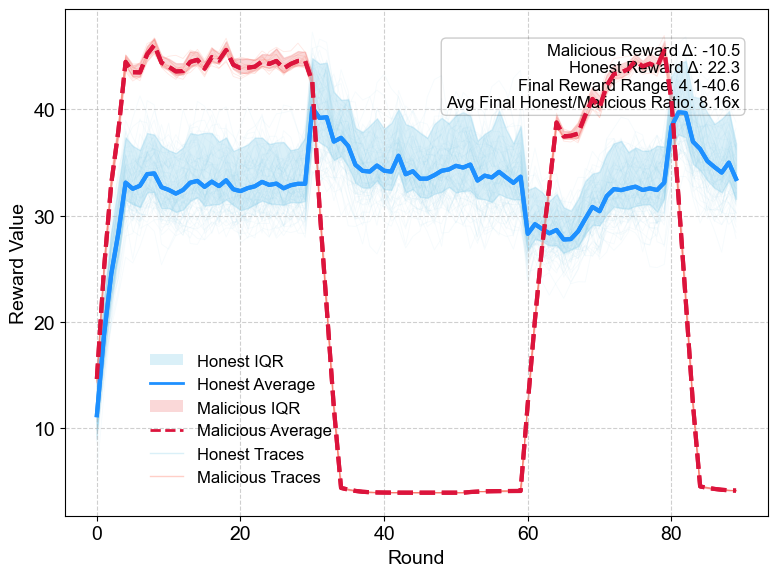


所有模拟和报告生成完毕。


In [39]:
N =100
CS = 5
Phase = 80
Base = 1200
rep_exponent = 0.5
stake_weight = 0.4
R = 90
# ================== Main Program ==================
if __name__ == "__main__":
    # Set fixed random seed for reproducibility
    np.random.seed(1411758002)
    import random
    random.seed(1411758002)
    
    
    # Initialize FL Systems with different malicious ratios
    systems = {
        # "with_malicious_0p10": FLSystem(
        #     num_nodes=N,
        #     base_reward=Base,
        #     committee_size=CS,  # Desired committee size
        #     stake_weight=stake_weight,
        #     rep_exponent= rep_exponent,
        #     malicious_ratio=0.1,  # 10% malicious nodes
        #     phase_switch_round=Phase,
        #     # Sybil resistance not considered
        # ),
        "with_malicious_0p15": FLSystem(
            num_nodes=N,
            base_reward=Base,
            committee_size=CS,  # Desired committee size
            stake_weight=stake_weight,
            rep_exponent=rep_exponent,
            malicious_ratio=0.15,  # 15% malicious nodes
            phase_switch_round=Phase,
            # sybil_resistance=False  # Sybil resistance not considered
        ),
        # "with_malicious_0p20": FLSystem(
        #     num_nodes=N,
        #     base_reward=Base,
        #     committee_size=CS,  # Desired committee size
        #     stake_weight=stake_weight,
        #     rep_exponent=rep_exponent,
        #     malicious_ratio=0.2,  # 20% malicious nodes
        #     phase_switch_round=Phase,
        #     # sybil_resistance=False  # Sybil resistance not considered
        # ),
        # "with_malicious_0p25": FLSystem(
        #     num_nodes=N,
        #     base_reward=Base,
        #     committee_size=CS,  # Desired committee size
        #     stake_weight=stake_weight,
        #     rep_exponent=rep_exponent,
        #     malicious_ratio=0.25,  # 25% malicious nodes
        #     phase_switch_round=Phase,
        #     # sybil_resistance=False  # Sybil resistance not considered
        # ),
        # "with_malicious_0p30": FLSystem(
        #     num_nodes=N,
        #     base_reward=Base,
        #     committee_size=CS,  # Desired committee size
        #     stake_weight=stake_weight,
        #     rep_exponent=rep_exponent,
        #     malicious_ratio=0.3,  # 30% malicious nodes
        #     phase_switch_round=Phase,
            # sybil_resistance=False  # Sybil resistance not considered
        # ),
        # "without_malicious": FLSystem(
        #     num_nodes=N,
        #     base_reward=Base,
        #     committee_size=CS,
        #     stake_weight=stake_weight,
        #     rep_exponent=rep_exponent,
        #     malicious_ratio=0.0,  # No malicious nodes
        #     phase_switch_round=30,
        #     # sybil_resistance=False
        # )
    }
    
    # Define the number of rounds for simulations
    rounds_with_malicious = R
    rounds_without_malicious = R

    # Run Simulations for systems with malicious nodes
    print("开始运行包含恶意节点的模拟...")
    # for _ in tqdm(range(rounds_with_malicious), desc="包含恶意节点"):
    #     for key in ["with_malicious_0p10", "with_malicious_0p15", "with_malicious_0p20", "with_malicious_0p25", "with_malicious_0p30"]:
    #         systems[key].run_round()
    for _ in tqdm(range(rounds_with_malicious), desc="包含恶意节点"):
        for key in ["with_malicious_0p15"]:
            systems[key].run_round()
    
    # Run Simulations for system without malicious nodes
    # print("\n开始运行不包含恶意节点的模拟...")
    # for _ in tqdm(range(rounds_without_malicious), desc="不包含恶意节点"):
    #     systems["without_malicious"].run_round()
    
    # Generate Reports
    folderpath = f"./exp_res/phase{Phase}/"
    print("\n生成模拟报告...")
    for key in systems:
        filename = f"{folderpath}simulation_report_N{N}_{key}.csv"
        generate_simulation_report(systems[key], filename=filename)
    
    # Verify Committee Sizes
    def verify_committee_size(system, expected_size=CS):
        """
        Verify that each committee in the history meets the expected size.
        """
        for round_num, committee in enumerate(system.committee_history, 1):
            if len(committee) != expected_size:
                print(f"Round {round_num}: Committee size {len(committee)} does not match expected {expected_size}.")
        print("Verification complete.")
    
    # Verify committee sizes for all systems
    print("\n验证所有系统的委员会规模...")
    for key in systems:
        print(f"\n验证系统 '{key}' 的委员会规模...")
        verify_committee_size(systems[key], expected_size=CS)
    
    # Generate Visualization for each system
    print("\n生成系统的可视化分析图表...")
    for key in systems:
        print(key)
        label = "With Malicious Nodes" if "with_malicious" in key else "Without Malicious Nodes"
        print(f"生成系统 '{key}' 的图表...")
        plot_metrics(systems[key], label=key)
    
    print("\n所有模拟和报告生成完毕。")


开始运行包含恶意节点的模拟...


包含恶意节点: 100%|██████████| 90/90 [00:02<00:00, 40.24it/s]



生成模拟报告...
Round metrics saved to ./exp_res/phase90/simulation_report_N100_with_malicious_0p15_round_metrics.csv
Node summary metrics saved to ./exp_res/phase90/simulation_report_N100_with_malicious_0p15_node_summary.csv

验证所有系统的委员会规模...

验证系统 'with_malicious_0p15' 的委员会规模...
Verification complete.

生成系统的可视化分析图表...
with_malicious_0p15
生成系统 'with_malicious_0p15' 的图表...


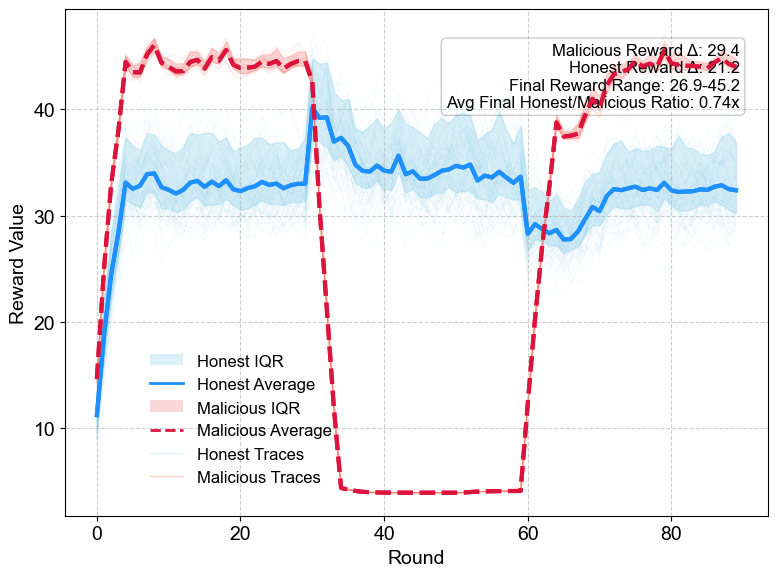


所有模拟和报告生成完毕。


In [40]:
N =100
CS = 5
Phase = 90
Base = 1200
rep_exponent = 0.5
stake_weight = 0.4
R = 90
# ================== Main Program ==================
if __name__ == "__main__":
    # Set fixed random seed for reproducibility
    np.random.seed(1411758002)
    import random
    random.seed(1411758002)
    
    
    # Initialize FL Systems with different malicious ratios
    systems = {
        # "with_malicious_0p10": FLSystem(
        #     num_nodes=N,
        #     base_reward=Base,
        #     committee_size=CS,  # Desired committee size
        #     stake_weight=stake_weight,
        #     rep_exponent= rep_exponent,
        #     malicious_ratio=0.1,  # 10% malicious nodes
        #     phase_switch_round=Phase,
        #     # Sybil resistance not considered
        # ),
        "with_malicious_0p15": FLSystem(
            num_nodes=N,
            base_reward=Base,
            committee_size=CS,  # Desired committee size
            stake_weight=stake_weight,
            rep_exponent=rep_exponent,
            malicious_ratio=0.15,  # 15% malicious nodes
            phase_switch_round=Phase,
            # sybil_resistance=False  # Sybil resistance not considered
        ),
        # "with_malicious_0p20": FLSystem(
        #     num_nodes=N,
        #     base_reward=Base,
        #     committee_size=CS,  # Desired committee size
        #     stake_weight=stake_weight,
        #     rep_exponent=rep_exponent,
        #     malicious_ratio=0.2,  # 20% malicious nodes
        #     phase_switch_round=Phase,
        #     # sybil_resistance=False  # Sybil resistance not considered
        # ),
        # "with_malicious_0p25": FLSystem(
        #     num_nodes=N,
        #     base_reward=Base,
        #     committee_size=CS,  # Desired committee size
        #     stake_weight=stake_weight,
        #     rep_exponent=rep_exponent,
        #     malicious_ratio=0.25,  # 25% malicious nodes
        #     phase_switch_round=Phase,
        #     # sybil_resistance=False  # Sybil resistance not considered
        # ),
        # "with_malicious_0p30": FLSystem(
        #     num_nodes=N,
        #     base_reward=Base,
        #     committee_size=CS,  # Desired committee size
        #     stake_weight=stake_weight,
        #     rep_exponent=rep_exponent,
        #     malicious_ratio=0.3,  # 30% malicious nodes
        #     phase_switch_round=Phase,
            # sybil_resistance=False  # Sybil resistance not considered
        # ),
        # "without_malicious": FLSystem(
        #     num_nodes=N,
        #     base_reward=Base,
        #     committee_size=CS,
        #     stake_weight=stake_weight,
        #     rep_exponent=rep_exponent,
        #     malicious_ratio=0.0,  # No malicious nodes
        #     phase_switch_round=30,
        #     # sybil_resistance=False
        # )
    }
    
    # Define the number of rounds for simulations
    rounds_with_malicious = R
    rounds_without_malicious = R

    # Run Simulations for systems with malicious nodes
    print("开始运行包含恶意节点的模拟...")
    # for _ in tqdm(range(rounds_with_malicious), desc="包含恶意节点"):
    #     for key in ["with_malicious_0p10", "with_malicious_0p15", "with_malicious_0p20", "with_malicious_0p25", "with_malicious_0p30"]:
    #         systems[key].run_round()
    for _ in tqdm(range(rounds_with_malicious), desc="包含恶意节点"):
        for key in ["with_malicious_0p15"]:
            systems[key].run_round()
    
    # Run Simulations for system without malicious nodes
    # print("\n开始运行不包含恶意节点的模拟...")
    # for _ in tqdm(range(rounds_without_malicious), desc="不包含恶意节点"):
    #     systems["without_malicious"].run_round()
    
    # Generate Reports
    folderpath = f"./exp_res/phase{Phase}/"
    print("\n生成模拟报告...")
    for key in systems:
        filename = f"{folderpath}simulation_report_N{N}_{key}.csv"
        generate_simulation_report(systems[key], filename=filename)
    
    # Verify Committee Sizes
    def verify_committee_size(system, expected_size=CS):
        """
        Verify that each committee in the history meets the expected size.
        """
        for round_num, committee in enumerate(system.committee_history, 1):
            if len(committee) != expected_size:
                print(f"Round {round_num}: Committee size {len(committee)} does not match expected {expected_size}.")
        print("Verification complete.")
    
    # Verify committee sizes for all systems
    print("\n验证所有系统的委员会规模...")
    for key in systems:
        print(f"\n验证系统 '{key}' 的委员会规模...")
        verify_committee_size(systems[key], expected_size=CS)
    
    # Generate Visualization for each system
    print("\n生成系统的可视化分析图表...")
    for key in systems:
        print(key)
        label = "With Malicious Nodes" if "with_malicious" in key else "Without Malicious Nodes"
        print(f"生成系统 '{key}' 的图表...")
        plot_metrics(systems[key], label=key)
    
    print("\n所有模拟和报告生成完毕。")


Optimal z: 1.0000
Optimal Contribution C_i*: 10.0000


/var/folders/8z/1cnkmz4s4233_90z9hks3tbr0000gn/T/ipykernel_62961/3518142354.py:20: RuntimeWarning: invalid value encountered in sqrt
  rhs = A / (np.sqrt(C_max) * np.sqrt(z))
/var/folders/8z/1cnkmz4s4233_90z9hks3tbr0000gn/T/ipykernel_62961/3518142354.py:27: RuntimeWarning: The iteration is not making good progress, as measured by the 
 improvement from the last ten iterations.
  z_solution, = fsolve(f, z_initial)


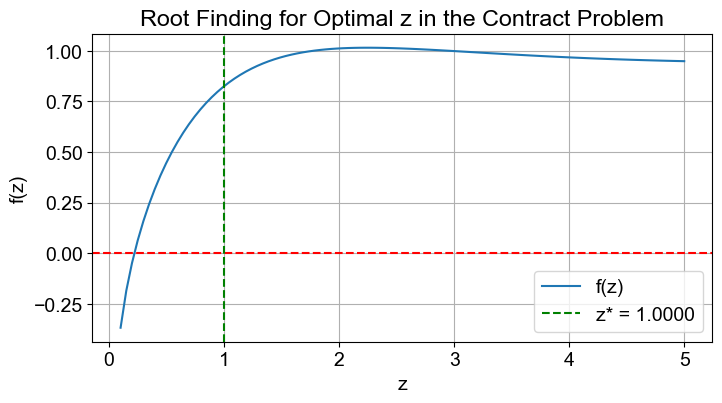

In [41]:
import numpy as np
from scipy.optimize import fsolve
import matplotlib.pyplot as plt

# Given parameters (example values)
X_c = 10.0          # Scaling factor for contribution impact
tau_i = 5.0         # Completion time for the task
omega1 = 0.5        # Weight for violation type 1 (example)
VSL_1 = 0.2         # Normalized violation level for violation type 1 (example)
C_max = 10.0        # Normalization constant for contribution

# Compute constant A = (tau_i * exp(omega1 * VSL_1)) / X_c
A = (tau_i * np.exp(omega1 * VSL_1)) / X_c

# Define the function f(z) that we want to solve: f(z) = 0
def f(z):
    # Left-hand side: 1 - exp(-z) + z * exp(-z)
    lhs = 1 - np.exp(-z) + z * np.exp(-z)
    # Right-hand side: A / (sqrt(C_max) * sqrt(z))
    rhs = A / (np.sqrt(C_max) * np.sqrt(z))
    return lhs - rhs

# Provide an initial guess for z
z_initial = 1.0

# Solve for z using fsolve
z_solution, = fsolve(f, z_initial)
C_i_optimal = z_solution * C_max

print(f"Optimal z: {z_solution:.4f}")
print(f"Optimal Contribution C_i*: {C_i_optimal:.4f}")

# Plot f(z) to visualize the root
z_values = np.linspace(0.1, 5, 100)  # start from 0.1 to avoid division by zero
f_values = [f(z) for z in z_values]

plt.figure(figsize=(8, 4))
plt.plot(z_values, f_values, label='f(z)')
plt.axhline(0, color='red', linestyle='--')
plt.axvline(z_solution, color='green', linestyle='--', label=f'z* = {z_solution:.4f}')
plt.xlabel('z')
plt.ylabel('f(z)')
plt.title('Root Finding for Optimal z in the Contract Problem')
plt.legend()
plt.grid(True)
plt.show()


In [42]:
def optimize_contract(lambda_val, gamma, rho, omega, vsl):
    # 计算最优贡献值
    C_star = (lambda_val / gamma) * np.exp(-omega * vsl)
    
    # 计算押金
    S_star = (gamma * C_star**2) / (2 * rho * (1 - np.exp(-omega * vsl)))
    
    # 计算奖励
    R_star = (gamma * C_star**2) / (2 * np.exp(-omega * vsl)) + rho * S_star * (np.exp(omega * vsl) - 1)
    
    return C_star, S_star, R_star

# 示例参数
lambda_val = 1.0  # 贡献单价
gamma = 0.1       # 成本系数
rho = 0.5         # 押金利用率
omega = 0.2       # 违规权重
vsl = 0.3         # 违规程度

C_opt, S_opt, R_opt = optimize_contract(lambda_val, gamma, rho, omega, vsl)
print(f"Optimal Contract: C={C_opt:.2f}, S={S_opt:.2f}, R={R_opt:.2f}")

Optimal Contract: C=9.42, S=152.30, R=9.42


Optimal z: 1.0000
Optimal Contribution C_i*: 10.0000


/var/folders/8z/1cnkmz4s4233_90z9hks3tbr0000gn/T/ipykernel_62961/3518142354.py:20: RuntimeWarning: invalid value encountered in sqrt
  rhs = A / (np.sqrt(C_max) * np.sqrt(z))
/var/folders/8z/1cnkmz4s4233_90z9hks3tbr0000gn/T/ipykernel_62961/3518142354.py:27: RuntimeWarning: The iteration is not making good progress, as measured by the 
 improvement from the last ten iterations.
  z_solution, = fsolve(f, z_initial)


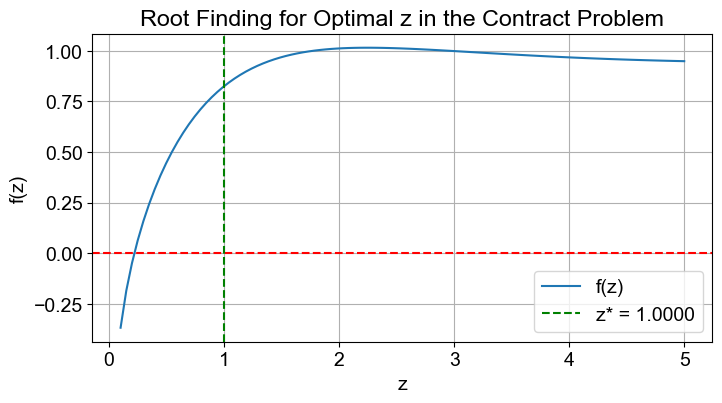

In [43]:
import numpy as np
from scipy.optimize import fsolve
import matplotlib.pyplot as plt

# Given parameters (example values)
X_c = 10.0          # Scaling factor for contribution impact
tau_i = 5.0         # Completion time for the task
omega1 = 0.5        # Weight for violation type 1 (example)
VSL_1 = 0.2         # Normalized violation level for violation type 1 (example)
C_max = 10.0        # Normalization constant for contribution

# Compute constant A = (tau_i * exp(omega1 * VSL_1)) / X_c
A = (tau_i * np.exp(omega1 * VSL_1)) / X_c

# Define the function f(z) that we want to solve: f(z) = 0
def f(z):
    # Left-hand side: 1 - exp(-z) + z * exp(-z)
    lhs = 1 - np.exp(-z) + z * np.exp(-z)
    # Right-hand side: A / (sqrt(C_max) * sqrt(z))
    rhs = A / (np.sqrt(C_max) * np.sqrt(z))
    return lhs - rhs

# Provide an initial guess for z
z_initial = 1.0

# Solve for z using fsolve
z_solution, = fsolve(f, z_initial)
C_i_optimal = z_solution * C_max

print(f"Optimal z: {z_solution:.4f}")
print(f"Optimal Contribution C_i*: {C_i_optimal:.4f}")

# Plot f(z) to visualize the root
z_values = np.linspace(0.1, 5, 100)  # start from 0.1 to avoid division by zero
f_values = [f(z) for z in z_values]

plt.figure(figsize=(8, 4))
plt.plot(z_values, f_values, label='f(z)')
plt.axhline(0, color='red', linestyle='--')
plt.axvline(z_solution, color='green', linestyle='--', label=f'z* = {z_solution:.4f}')
plt.xlabel('z')
plt.ylabel('f(z)')
plt.title('Root Finding for Optimal z in the Contract Problem')
plt.legend()
plt.grid(True)
plt.show()
